## Analysis and Plots

#### Libraries

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.path as mpath
import matplotlib.patches as patches
import matplotlib.cm as cm
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import cartopy.mpl.gridliner as gridliner
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
%matplotlib inline
import time
import cftime
import seaborn as sns
import calendar
import datetime
from pyproj import Proj, transform
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import scipy.ndimage
from scipy.interpolate import griddata

In [2]:
path = '/storage2/tkyeimiah'

In [3]:
start_time=time.time()

path = '/storage2/tkyeimiah'

aice_dh = xr.open_dataset(path+'/iHESP/EM1/HR-hist/aice_hist/aice_hist.nc')
aice_dp = xr.open_dataset(path+'/iHESP/EM1/HR-proj/aice_proj/aice_proj.nc')

hi_dh = xr.open_dataset(path+'/iHESP/EM1/HR-hist/hi_hist/hi_hist.nc')
hi_dp = xr.open_dataset(path+'/iHESP/EM1/HR-proj/hi_proj/hi_proj.nc')

end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.4227139949798584 seconds


In [4]:
def shift_month(ds):
    ds = ds.copy()  
    # Convert each cftime.DatetimeNoLeap to pandas datetime
    time_as_pd_datetime = [pd.Timestamp(date.year, date.month, date.day) for date in ds['time'].values]

    # Subtract one month
    time_as_pd_datetime = [date - pd.DateOffset(months=1) for date in time_as_pd_datetime]

    # Convert back to cftime.DatetimeNoLeap
    time_as_cftime = [cftime.DatetimeNoLeap(date.year, date.month, date.day) for date in time_as_pd_datetime]

    # Replace the time coordinate in the dataset
    ds['time'] = time_as_cftime
    
    return ds

### CESM1.3-HR

In [5]:
aice_hist=shift_month(aice_dh['aice'])
aice_proj=shift_month(aice_dp['aice'])

tarea_hist=aice_dh['uarea']
tarea_proj=aice_dp['uarea']

In [6]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69


# Create a mask for Labrador coast 
mask_hist = ((aice_hist.TLAT >= lat_min) & (aice_hist.TLAT <= lat_max) &
        (aice_hist.TLON >= lon_min) & (aice_hist.TLON <= lon_max))

mask_hist2 = ((tarea_hist.TLAT >= lat_min) & (tarea_hist.TLAT <= lat_max) &
        (tarea_hist.TLON >= lon_min) & (tarea_hist.TLON <= lon_max))

mask_proj = ((aice_proj.TLAT >= lat_min) & (aice_proj.TLAT <= lat_max) &
        (aice_proj.TLON >= lon_min) & (aice_proj.TLON <= lon_max))

mask_proj2 = ((tarea_proj.TLAT >= lat_min) & (tarea_proj.TLAT <= lat_max) &
        (tarea_proj.TLON >= lon_min) & (tarea_proj.TLON <= lon_max))

# Apply the mask to the aice variable
aice_hist_region_ =aice_hist.where(mask_hist, drop=True)
tarea_hist_region_=tarea_hist.where(mask_hist2, drop=True)
aice_proj_region_ =aice_proj.where(mask_proj, drop=True)
tarea_proj_region_=tarea_proj.where(mask_proj2, drop=True)

#### SIE

In [7]:
sic_greater_15hist = xr.where(aice_hist_region_ >= 15, 1, 0)
sic_greater_15proj = xr.where(aice_proj_region_ >= 15, 1, 0)

aice_hist_region = (sic_greater_15hist * tarea_hist_region_)/1e12
aice_proj_region = (sic_greater_15proj * tarea_proj_region_)/1e12

In [8]:
#plot for article
model_1991_00 = aice_hist_region.sel(time=slice('1991-01-01','2000-12-31'))
model_2001_05 = aice_hist_region.sel(time=slice('2001-01-01','2005-12-31'))
model_2006_20 = aice_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
model_2001_20 = xr.concat([model_2001_05, model_2006_20], dim='time')
model_2041_60 = aice_proj_region.sel(time=slice('2041-01-01','2060-12-31'))
model_2081_100= aice_proj_region.sel(time=slice('2081-01-01','2100-12-31'))

In [9]:
model_1991_00_monthly = model_1991_00.groupby('time.month').mean('time').sum(('nj','ni'))
model_2001_20_monthly = model_2001_20.groupby('time.month').mean('time').sum(('nj','ni'))

model_1991_00_monmax = model_1991_00.groupby('time.month').max('time').sum(('nj','ni'))
model_2001_20_monmax = model_2001_20.groupby('time.month').max('time').sum(('nj','ni'))

model_1991_00_monmin = model_1991_00.groupby('time.month').min('time').sum(('nj','ni'))
model_2001_20_monmin = model_2001_20.groupby('time.month').min('time').sum(('nj','ni'))

#### SIC

In [10]:
#plot for article
model_sic_1991_00 = aice_hist_region_.sel(time=slice('1991-01-01','2000-12-31'))
model_sic_2001_05 = aice_hist_region_.sel(time=slice('2001-01-01','2005-12-31'))
model_sic_2006_20 = aice_proj_region_.sel(time=slice('2006-01-01','2020-12-31'))
model_sic_2001_20 = xr.concat([model_sic_2001_05, model_sic_2006_20], dim='time')
model_sic_2041_60 = aice_proj_region_.sel(time=slice('2041-01-01','2060-12-31'))
model_sic_2081_100= aice_proj_region_.sel(time=slice('2081-01-01','2100-12-31'))

In [11]:
model_hist=aice_hist_region_.sel(time=slice('1990-01-01','2005-12-31'))
model_proj=aice_proj_region_.sel(time=slice('2006-01-01','2020-12-31'))
model_CT_sel= xr.concat([model_hist, model_proj], dim='time')

#### SIT

In [12]:
hi_hist=shift_month(hi_dh['hi'])
hi_proj=shift_month(hi_dp['hi'])

In [13]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_hist3 = ((hi_hist.TLAT >= lat_min) & (hi_hist.TLAT <= lat_max) &
              (hi_hist.TLON >= lon_min) & (hi_hist.TLON <= lon_max))


mask_proj3 = ((hi_proj.TLAT >= lat_min) & (hi_proj.TLAT <= lat_max) &
              (hi_proj.TLON >= lon_min) & (hi_proj.TLON <= lon_max))

# Apply the mask to the aice variable
hi_hist_region=hi_hist.where(mask_hist3, drop=True)
hi_proj_region=hi_proj.where(mask_proj3, drop=True)

hi_hist_region1=hi_hist_region.where(aice_hist_region_ >= 15, np.nan)
hi_proj_region1=hi_proj_region.where(aice_proj_region_ >= 15, np.nan)

In [14]:
#hi_hist_region1=hi_hist_region
#hi_proj_region1=hi_proj_region

In [15]:
#plot for article
model_hi_1991_00 = hi_hist_region.sel(time=slice('1991-01-01','2000-12-31'))
model_hi_2001_05 = hi_hist_region.sel(time=slice('2001-01-01','2005-12-31'))
model_hi_2006_20 = hi_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
model_hi_2001_20 = xr.concat([model_hi_2001_05, model_hi_2006_20], dim='time')
model_hi_2041_60 = hi_proj_region.sel(time=slice('2041-01-01','2060-12-31'))
model_hi_2081_100= hi_proj_region.sel(time=slice('2081-01-01','2100-12-31'))

In [16]:
#plot for article
model_hi_1991_00b = hi_hist_region1.sel(time=slice('1991-01-01','2000-12-31'))
model_hi_2001_05b = hi_hist_region1.sel(time=slice('2001-01-01','2005-12-31'))
model_hi_2006_20b = hi_proj_region1.sel(time=slice('2006-01-01','2020-12-31'))
model_hi_2001_20b = xr.concat([model_hi_2001_05b, model_hi_2006_20b], dim='time')
model_hi_2041_60b = hi_proj_region1.sel(time=slice('2041-01-01','2060-12-31'))
model_hi_2081_100b= hi_proj_region1.sel(time=slice('2081-01-01','2100-12-31'))

In [17]:
model_hi_1991_00_monthly = model_hi_1991_00b.groupby('time.month').mean('time').mean(('nj','ni'))
model_hi_2001_20_monthly = model_hi_2001_20b.groupby('time.month').mean('time').mean(('nj','ni'))

model_hi_1991_00_monmax = model_hi_1991_00b.groupby('time.month').max('time').mean(('nj','ni'))
model_hi_2001_20_monmax = model_hi_2001_20b.groupby('time.month').max('time').mean(('nj','ni'))

model_hi_1991_00_monmin = model_hi_1991_00b.groupby('time.month').min('time').mean(('nj','ni'))
model_hi_2001_20_monmin = model_hi_2001_20b.groupby('time.month').min('time').mean(('nj','ni'))

### CESM-LR

In [18]:
aice_hi_dh_13lr = xr.open_dataset(path+'/iHESP/EM1/LR-hist/aice_hi_hist/aice_hi_hist.nc')
aice_hi_dp_13lr  = xr.open_dataset(path+'/iHESP/EM1/LR-proj/aice_hi_proj/aice_hi_proj.nc')
Cesm_lr=xr.open_dataset(path+'/CESM2-LE/aice/EM_1001.nc')

In [19]:
#aice
aice_hist_13lr=shift_month(aice_hi_dh_13lr['aice'])
aice_proj_13lr=shift_month(aice_hi_dp_13lr['aice'])

aice_hist_dx_13lr = aice_hi_dh_13lr['dxt']
aice_hist_dy_13lr = aice_hi_dh_13lr['dyt']
aice_proj_dx_13lr = aice_hi_dp_13lr['dxt']
aice_proj_dy_13lr = aice_hi_dp_13lr['dyt']

#area
tarea_hist_13lr = aice_hist_dx_13lr * aice_hist_dy_13lr
tarea_proj_13lr = aice_proj_dx_13lr * aice_proj_dy_13lr

In [20]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69


# Create a mask for Labrador coast 
mask_hist = ((aice_hist_13lr.TLAT >= lat_min) & (aice_hist_13lr.TLAT <= lat_max) &
        (aice_hist_13lr.TLON >= lon_min) & (aice_hist_13lr.TLON <= lon_max))

mask_proj = ((aice_proj_13lr.TLAT >= lat_min) & (aice_proj_13lr.TLAT <= lat_max) &
        (aice_proj_13lr.TLON >= lon_min) & (aice_proj_13lr.TLON <= lon_max))

####
mask_hist1 = ((tarea_hist_13lr.TLAT >= lat_min) & (tarea_hist_13lr.TLAT <= lat_max) &
        (tarea_hist_13lr.TLON >= lon_min) & (tarea_hist_13lr.TLON <= lon_max))

mask_proj1 = ((tarea_proj_13lr.TLAT >= lat_min) & (tarea_proj_13lr.TLAT <= lat_max) &
        (aice_proj_13lr.TLON >= lon_min) & (tarea_proj_13lr.TLON <= lon_max))

# Apply the mask to the aice variable
aice_hist_13lr_region_ =aice_hist_13lr.where(mask_hist, drop=True)
aice_proj_13lr_region_ =aice_proj_13lr.where(mask_proj, drop=True)
tarea_hist_13lr_region_=tarea_hist_13lr.where(mask_hist1, drop=True)
tarea_proj_13lr_region_=tarea_proj_13lr.where(mask_proj1, drop=True)

### SIE

In [21]:
sic_greater_15hist_13lr = xr.where(aice_hist_13lr_region_ >= 15, 1, 0)
sic_greater_15proj_13lr = xr.where(aice_proj_13lr_region_ >= 15, 1, 0)

aice_hist_13lr_region = (sic_greater_15hist_13lr * tarea_hist_13lr_region_)/1e12
aice_proj_13lr_region = (sic_greater_15proj_13lr * tarea_proj_13lr_region_)/1e12

### SIT


In [22]:
hi_hist_13lr=shift_month(aice_hi_dh_13lr['hi'])
hi_proj_13lr=shift_month(aice_hi_dp_13lr['hi'])

In [23]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_hist3 = ((hi_hist_13lr.TLAT >= lat_min) & (hi_hist_13lr.TLAT <= lat_max) &
              (hi_hist_13lr.TLON >= lon_min) & (hi_hist_13lr.TLON <= lon_max))

mask_proj3 = ((hi_proj_13lr.TLAT >= lat_min) & (hi_proj_13lr.TLAT <= lat_max) &
              (hi_proj_13lr.TLON >= lon_min) & (hi_proj_13lr.TLON <= lon_max))

# Apply the mask to the aice variable
hi_hist_13lr_region=hi_hist_13lr.where(mask_hist3, drop=True)
hi_proj_13lr_region=hi_proj_13lr.where(mask_proj3, drop=True)

hi_hist_13lr_region1=hi_hist_13lr_region.where(aice_hist_13lr_region_ >= 15, np.nan)
hi_proj_13lr_region1=hi_proj_13lr_region.where(aice_proj_13lr_region_ >= 15, np.nan)

### Nunatsiavut Research Center -Nain

In [24]:
path_nain='/storage2/tkyeimiah/Nain_data/Nain-'

In [25]:
sat = pd.read_excel(path_nain+'/Satosoak-2009_2023.xlsx')
tak = pd.read_excel(path_nain+'/Taktok-2009_2023.xlsx')

In [26]:
# Load the data
sat = pd.read_excel(path_nain + '/Satosoak-2009_2023.xlsx')
tak = pd.read_excel(path_nain + '/Taktok-2009_2023.xlsx')

# Filter data from 2009 to 2020
sat_filtered = sat[(sat['Year'] >= 2009) & (sat['Year'] <= 2020)]
tak_filtered = tak[(tak['Year'] >= 2009) & (tak['Year'] <= 2020)]

# Group by Month and calculate the mean of Hice_Mean
sat_mean_monthly = sat_filtered.groupby('Month')['Hice_Mean'].mean().reset_index()
tak_mean_monthly = tak_filtered.groupby('Month')['Hice_Mean'].mean().reset_index()

In [27]:
# Create a DataFrame with all months to include missing months

all_months = pd.DataFrame({'Month': range(1, 13)})

# Merge with the all_months DataFrame to include all months
sat_mean_monthly = pd.merge(all_months, sat_mean_monthly, on='Month', how='left')
tak_mean_monthly = pd.merge(all_months, tak_mean_monthly, on='Month', how='left')

### Haversine Formula

The Haversine formula calculates the distance between two points on the surface of a sphere (great-circle distance), given their latitude and longitude.

Let:
- $(\phi_1, \lambda_1)$ be the latitude and longitude of the first point in radians,
- $(\phi_2, \lambda_2)$ be the latitude and longitude of the second point in radians,
- $R$ be the radius of the Earth (mean radius = 6,371 km).

The formula is given by:

1. Compute the differences in latitude and longitude:
   $$
   \Delta \phi = \phi_2 - \phi_1
   $$
   $$
   \Delta \lambda = \lambda_2 - \lambda_1
   $$

2. Apply the Haversine formula:
   $$
   a = \sin^2\left(\frac{\Delta \phi}{2}\right) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \sin^2\left(\frac{\Delta \lambda}{2}\right)
   $$
   $$
   c = 2 \cdot \text{atan2}\left(\sqrt{a}, \sqrt{1-a}\right)
   $$

3. Calculate the distance:
   $$
   d = R \cdot c
   $$

Where:
- $\sin$ is the sine function,
- $\cos$ is the cosine function,
- $\text{atan2}$ is the arctangent function with two arguments,
- $d$ is the distance between the two points.

### Example Calculation

Given two points:
- Point 1: Latitude $\phi_1 = 56.425133^\circ$, Longitude $\lambda_1 = 298.2765^\circ$
- Point 2: Latitude $\phi_2 = 56.4324^\circ$, Longitude $\lambda_2 = 298.543^\circ$

Convert the latitudes and longitudes from degrees to radians:
$$
\phi_1 = 56.425133 \times \frac{\pi}{180}
$$
$$
\lambda_1 = 298.2765 \times \frac{\pi}{180}
$$
$$
\phi_2 = 56.4324 \times \frac{\pi}{180}
$$
$$
\lambda_2 = 298.543 \times \frac{\pi}{180}
$$

Then apply the Haversine formula as described above to find the distance $d$.


## CIS

In [28]:
area=xr.open_dataset(path+'/Obs/CIS/CIS_processed/Area.nc')
obs=xr.open_dataset(path+'/Obs/CIS/CIS_combined/CT_all_combined.nc')

obs_CA=xr.open_dataset(path+'/Obs/CIS/CIS_combined/CA_all_combined.nc')
obs_CB=xr.open_dataset(path+'/Obs/CIS/CIS_combined/CB_all_combined.nc')
obs_CC=xr.open_dataset(path+'/Obs/CIS/CIS_combined/CC_all_combined.nc')
obs_SA=xr.open_dataset(path+'/Obs/CIS/CIS_combined/SA_all_combined.nc')
obs_SB=xr.open_dataset(path+'/Obs/CIS/CIS_combined/SB_all_combined.nc')
obs_SC=xr.open_dataset(path+'/Obs/CIS/CIS_combined/SC_all_combined.nc')

In [29]:
#obs_CT=obs['CT']
obs_area=area['area']
obs_CT=obs['CT']

#### Applying the common continent

In [30]:
# Load the mask (binary array)
continent_mask = np.load('/storage2/tkyeimiah/biggestCommonContinent.npy') 

# Convert the mask to an xarray DataArray
mask_da = xr.DataArray(continent_mask, dims=['rlat', 'rlon']) 

In [31]:
# Apply the mask
CT1_resampled= obs_CT.where(mask_da == 0)

In [32]:
lat_min, lat_max = 51, 69
lon_min, lon_max =-73, -45

# Create a mask for Labrador coast 
maskobs1 = ((obs_area.lat>= lat_min) & (obs_area.lat <= lat_max) & (obs_area.lon >= lon_min) & (obs_area.lon<= lon_max))
maskobs2 = ((CT1_resampled.lat>= lat_min) & (CT1_resampled.lat <= lat_max) & (CT1_resampled.lon >= lon_min) & (CT1_resampled.lon<= lon_max))

obs_CT_region =CT1_resampled.where(maskobs2, drop=True)
obs_area_region =obs_area.where(maskobs1, drop=True)

In [33]:
obs_CT_resampled=obs_CT_region

#### SIE

In [34]:
#replacing all ice 15 % and above with 1 and less with 0
obs_greater_15 = xr.where(obs_CT_resampled>= 0.15, 1, 0)

#calculating the SIE
obs_CT_region=(obs_greater_15 * obs_area_region)/1e6

In [35]:
#sel
cis_1991_00 = obs_CT_region.sel(time=slice('1991', '2000'))
cis_2001_20 = obs_CT_region.sel(time=slice('2001', '2020'))

In [36]:
cis_1991_00_monthly = cis_1991_00.groupby('time.month').mean('time').sum(['rlat','rlon'])
cis_2001_20_monthly = cis_2001_20.groupby('time.month').mean('time').sum(['rlat','rlon'])

cis_1991_00_monmin = cis_1991_00.groupby('time.month').min('time').sum(['rlat','rlon'])
cis_2001_20_monmin = cis_2001_20.groupby('time.month').min('time').sum(['rlat','rlon'])

cis_1991_00_monmax = cis_1991_00.groupby('time.month').max('time').sum(['rlat','rlon'])
cis_2001_20_monmax = cis_2001_20.groupby('time.month').max('time').sum(['rlat','rlon'])

In [37]:
obs_1991_00 = obs_CT_region.sel(time=slice('1991', '2000'))
obs_2001_10 = obs_CT_region.sel(time=slice('2001', '2010'))
obs_2011_20 = obs_CT_region.sel(time=slice('2011', '2020'))

#### SIC

In [38]:
cis_sic_1991_00 = obs_CT_resampled.sel(time=slice('1991', '2000'))
cis_sic_2000_20 = obs_CT_resampled.sel(time=slice('2001', '2020'))

obs_CT_sel=obs_CT_resampled

#### SIT

In [39]:
obs_CAresampled= obs_CA.where(mask_da == 0)
obs_CBresampled= obs_CB.where(mask_da == 0)
obs_CCresampled= obs_CC.where(mask_da == 0)
obs_SAresampled= obs_SA.where(mask_da == 0)
obs_SBresampled= obs_SB.where(mask_da == 0)
obs_SCresampled= obs_SC.where(mask_da == 0)

In [40]:
CA = obs_CAresampled ['CA']
CB = obs_CBresampled ['CB']
CC = obs_CCresampled ['CC']
SA = obs_SAresampled ['SA']
SB = obs_SBresampled ['SB']
SC = obs_SCresampled ['SC']

total_C = CA + CB + CC

In [41]:
obs_thick= ((CA * SA) + (CB * SB) + (CC * SC))/ total_C  

In [42]:
lat_min, lat_max = 51, 69
lon_min, lon_max =-73, -45

# Create a mask for Labrador coast 
mask_thick = ((obs_thick.lat>= lat_min) & (obs_thick.lat <= lat_max) & (obs_thick.lon >= lon_min) & (obs_thick.lon<= lon_max))
mask_total = ((total_C.lat>= lat_min) & (total_C.lat <= lat_max) & (total_C.lon >= lon_min) & (total_C.lon<= lon_max))

obs_thick_region =obs_thick.where(mask_thick, drop=True)
obs_total_region =total_C.where(mask_total, drop=True)

obs_thick_region1=obs_thick_region.where(obs_total_region >= 0.15, np.nan)

In [43]:
cis_total_c_1991_00 = obs_total_region.sel(time=slice('1991', '2000'))
cis_total_c_2001_20 = obs_total_region.sel(time=slice('2001', '2020'))

In [44]:
cis_thick_1991_00a = obs_thick_region.sel(time=slice('1991', '2000'))
cis_thick_2001_20a = obs_thick_region.sel(time=slice('2001', '2020'))

In [45]:
cis_thick_1991_00 = obs_thick_region1.sel(time=slice('1991', '2000'))
cis_thick_2001_20 = obs_thick_region1.sel(time=slice('2001', '2020'))
cis_thick_1990_20 = obs_thick_region1.sel(time=slice('1990', '2020'))

In [46]:
cis_thick_1991_00_monthly = cis_thick_1991_00.groupby('time.month').mean('time').mean(['rlat','rlon'])
cis_thick_2001_20_monthly = cis_thick_2001_20.groupby('time.month').mean('time').mean(['rlat','rlon'])

In [47]:
obs_thick_months=obs_thick_region1.groupby('time.month').mean('time')
obs_thick_months1=obs_thick_region.groupby('time.month').mean('time')

## CESM2-LE

In [48]:
start_time=time.time()

Cesm_lr=xr.open_dataset(path+'/CESM2-LE/aice/EM_1001.nc')

end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.015223026275634766 seconds


In [49]:
aice_lr=shift_month(Cesm_lr['aice'])
tarea_lr=Cesm_lr['uarea']

In [50]:
tarea_lr

<xarray.DataArray 'uarea' (nj: 384, ni: 320)>
[122880 values with dtype=float32]
Coordinates:
    TLON     (nj, ni) float32 ...
    TLAT     (nj, ni) float32 ...
    ULON     (nj, ni) float32 ...
    ULAT     (nj, ni) float32 ...
Dimensions without coordinates: nj, ni
Attributes:
    long_name:  area of U grid cells
    units:      m2

In [51]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_lr = ((aice_lr.TLAT >= lat_min) & (aice_lr.TLAT <= lat_max) &
        (aice_lr.TLON >= lon_min) & (aice_lr.TLON <= lon_max))

mask_lr2 = ((tarea_lr.TLAT >= lat_min) & (tarea_lr.TLAT <= lat_max) &
        (tarea_lr.TLON >= lon_min) & (tarea_lr.TLON <= lon_max))

# Apply the mask to the aice variable
aice_lr_region_ =aice_lr.where(mask_lr, drop=True)
tarea_lr_region_=tarea_lr.where(mask_lr2, drop=True)

In [52]:
aice_lr_region_

<xarray.DataArray 'aice' (time: 3012, nj: 50, ni: 38)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2100-12-01 00:00:00
    TLON     (nj, ni) float32 275.1 276.2 277.3 278.3 ... 1e+30 1e+30 1e+30
    TLAT     (nj, ni) float32 52.18 52.08 51.97 51.87 ... 1e+30 1e+30 1e+30
    ULON     (nj, ni) float32 275.7 276.8 277.8 278.9 ... 1e+30 1e+30 1e+30
    ULAT     (nj, ni) float32 52.35 52.24 52.13 52.03 ... 1e+30 1e+30 1e+30
Dimensions without coordinates: nj, ni
Attributes:
    long_name:     ice area  (aggregate)
    units:         1
    cell_methods:  time: mean
    time_rep:      averaged

#### SIE

In [53]:
sic_greater_lr_15 = xr.where(aice_lr_region_ >= 0.15, 1, 0)
aice_lr_region = (sic_greater_lr_15 * tarea_lr_region_)/1e12

#### SIT

In [54]:
Cesm_lr_hi=xr.open_dataset(path+'/CESM2-LE/hi/hi_1001.nc')

In [55]:
hi_lr=shift_month(Cesm_lr_hi['hi'])

In [56]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_hi_lr = ((hi_lr.TLAT >= lat_min) & (hi_lr.TLAT <= lat_max) &
        (hi_lr.TLON >= lon_min) & (hi_lr.TLON <= lon_max))


# Apply the mask to the aice variable
hi_lr_region1=hi_lr.where(mask_hi_lr, drop=True)
hi_lr_region=hi_lr_region1.where(aice_lr_region_ >= 0.15, np.nan)


### PLOT SECTION

### Fig 2

In [57]:
###article

#start_time = time.time()
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

model_cis_dt = [model_1991_00_monthly, model_2001_20_monthly, cis_1991_00_monthly, cis_2001_20_monthly]

hi_dt =[model_hi_1991_00_monthly, model_hi_2001_20_monthly]


cl = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
month_dt = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep']
lb = ['1991-2000', '2001-2020']

# First plot
for i in range (len(model_cis_dt)):
    if i <2:
        ls='-'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i], label=lb[i])
        #ax[0].fill_between(month_dt, np.append(mc_data_mn[i][9:],mc_data_mn[i][:9]),
                           #np.append(mc_data_mx[i][9:],mc_data_mx[i][:9]),color=cl[i], alpha=0.03)
        ax[0].legend(loc='upper right', bbox_to_anchor=(1.0,0.97))
        
    if i >=2:
        ls='--'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i])
        #ax[0].fill_between(month_dt, np.append(mc_data_mn[i][9:],mc_data_mn[i][:9]),
                           #np.append(mc_data_mx[i][9:],mc_data_mx[i][:9]),color=cl[i], alpha=0.03)
        
    ax[0].set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=14)
    ax[0].grid(alpha=0.15)
    
                 
# Second plot  
for i in range (len(hi_dt)):
    ls='-'
    ax[1].plot(month_dt, np.append(hi_dt[i][9:], hi_dt[i][:9]), linestyle=ls, color=cl[i], label=lb[i])
    #ax[1].fill_between(month_dt, np.append(hi_data_mn[i][9:],hi_data_mn[i][:9]),np.append(hi_data_mx[i][9:],hi_data_mx[i][:9]),
                       #color=cl[i], alpha=0.03)
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('Sea Ice Thickness [m]', fontsize=14)
    ax[1].set_xlabel('Year', fontsize=14)
    ax[1].grid(alpha=0.15)  

rectangle = patches.Rectangle((0.005, 0.81), 2, 0.15, edgecolor='lightgray',  facecolor='white',linewidth=1, zorder=10)
ax[0].add_patch(rectangle)

# Add CESM1.3-HR text and line
ax[0].text(0.11, 0.9, 'CESM1.3-HR', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.91, 0.91], color='black', transform=ax[0].transAxes, linestyle='-', zorder=11)

# Add CIS text and dashed line
ax[0].text(0.11, 0.835, 'CIS', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.85, 0.85], color='black', transform=ax[0].transAxes, linestyle='--', zorder=11)

    
ax[0].text(0.01, 0.95, 'a)',transform=ax[0].transAxes,  fontsize=14)
ax[1].text(0.01, 0.95, 'b)',transform=ax[1].transAxes,  fontsize=14)


plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig4.jpg', dpi=500, bbox_inches='tight')
plt.show()

### Fig 3

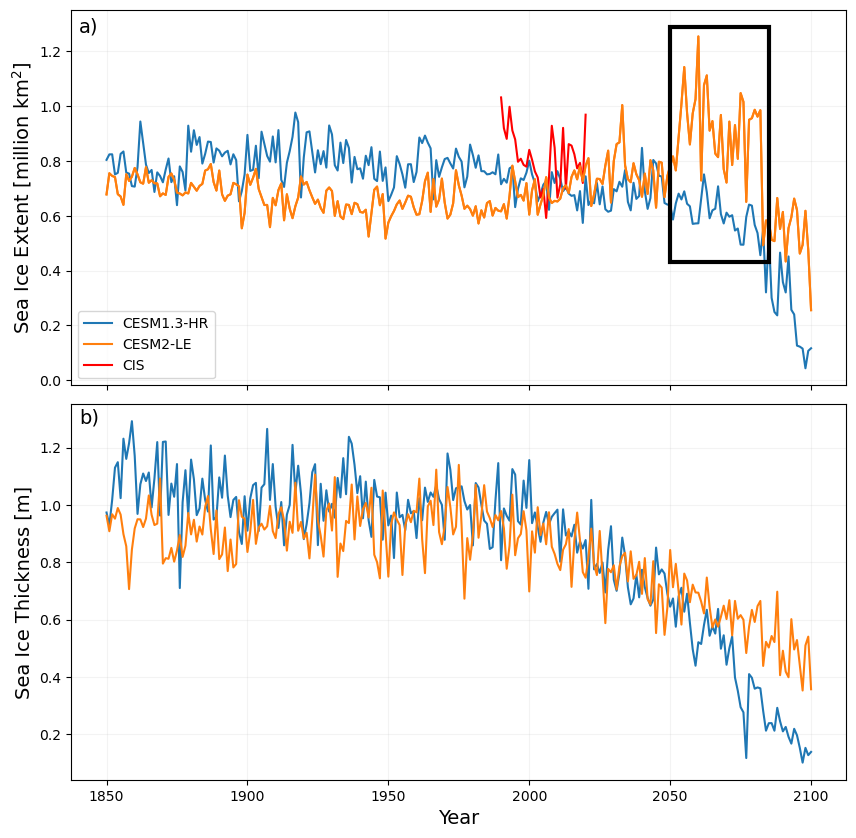

Execution time:  0.0 hours, 0.0 minutes, 0.015223026275634766 seconds


In [58]:

# SIE  : CESM1.3-HR
march_aice_hist = aice_hist_region.sel(time=slice('1850','2005'))[2::12].sum(('nj', 'ni'))
march_aice_proj = aice_proj_region.sel(time=slice('2006','2100'))[2::12].sum(('nj', 'ni'))
march_aice=xr.concat([march_aice_hist,march_aice_proj], dim='time')

# SIE : CIS
obs_SIE=obs_CT_region.sel(time=slice('1990','2020'))
obs_SIE_march=obs_SIE[2::12].sum(['rlat','rlon'])

# SIE  : LR-CESM
march_aice_LR = aice_lr_region.sel(time=slice('1850','2100'))[2::12].sum(('nj', 'ni'))


# SIT : CESM1.3-HR
march_hi_hist = hi_hist_region1.sel(time=slice('1850','2005'))[3::12].mean(('nj', 'ni'))
march_hi_proj = hi_proj_region1.sel(time=slice('2006','2100'))[3::12].mean(('nj', 'ni'))
march_hi=xr.concat([march_hi_hist,march_hi_proj], dim='time')

# SIT  : LR-CESM
march_hi_LR= hi_lr_region.sel(time=slice('1850','2100'))[3::12].mean(('nj', 'ni'))

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
years =np.arange(1850,2101,1)
#yearss =np.arange(1850,2101)

# First plot              
ax[0].plot(years, march_aice, label='CESM1.3-HR')
ax[0].plot(years, march_aice_LR, label='CESM2-LE', color='tab:orange')
ax[0].plot(np.arange(1990,2021), obs_SIE_march, color='red', label='CIS')
ax[0].set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=14)
ax[0].grid(alpha=0.15)
ax[0].legend(loc='lower left')               
# Second plot         
ax[1].plot(years, march_hi.fillna((0.08338354+0.1498341)/2), label='CESM1.3-HR')
ax[1].plot(years, march_hi_LR, label='CESM2-LE')
ax[1].set_ylabel('Sea Ice Thickness [m]', fontsize=14)
ax[1].grid(alpha=0.15)
#
ax[1].set_xlabel('Year', fontsize=14)

ax[0].text(0.01, 0.94, 'a)',transform=ax[0].transAxes,  fontsize=14)
ax[1].text(0.01, 0.95, 'b)',transform=ax[1].transAxes,  fontsize=14)

ax[0].plot(years, march_aice_LR, label='CESM2-LE')
rect=ax[0].add_patch(Rectangle((2050, 0.43), 35, 0.86, edgecolor='black',facecolor='none',lw=3,))
rect.set_zorder(10)
#rect1=ax[1].add_patch(Rectangle((2050, 0.07), 35, 0.5, edgecolor='black',facecolor='none',lw=3,))
#rect1.set_zorder(10)

plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig2a.jpg', dpi=500, bbox_inches='tight')
plt.show()

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")


### Fig 4

In [59]:
cis_sic_1991_00 = obs_CT_resampled.sel(time=slice('1991', '2000'))
cis_sic_2001_20 = obs_CT_resampled.sel(time=slice('2001', '2020'))
cis_sic_1991_00_=cis_sic_1991_00[2::12].mean('time').fillna(0)*100
cis_sic_2001_20_=cis_sic_2001_20[2::12].mean('time').fillna(0)*100

model_sic_1991_00_=model_sic_1991_00[2::12].mean('time')
model_sic_2001_20_=model_sic_2001_20[2::12].mean('time')
model_sic_2041_60_=model_sic_2041_60[2::12].mean('time')
model_sic_2081_100_=model_sic_2081_100[2::12].mean('time')

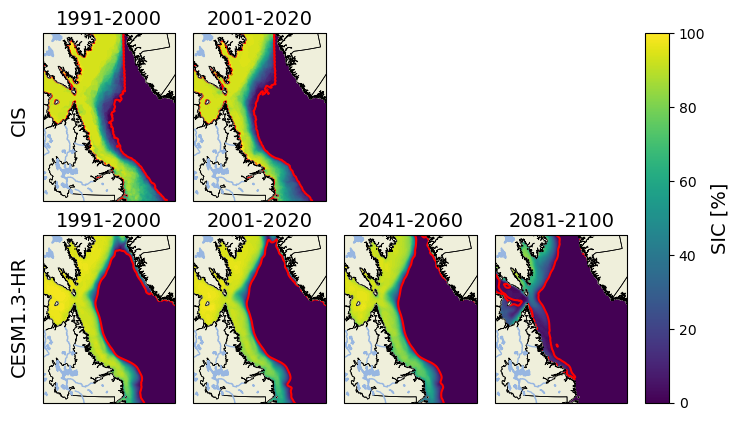

Execution time:  0.0 hours, 0.0 minutes, 56.88785457611084 seconds


In [60]:
#=========sic_region==max========================

fig = plt.figure(figsize=(8,4.8))
sic_data = [cis_sic_1991_00_, cis_sic_2001_20_,
            model_sic_1991_00_, model_sic_2001_20_, model_sic_2041_60_, model_sic_2081_100_]

#hi_data1 = [model_hi_1991_00, model_hi_2000_20, model_hi_2040_60, model_hi_2080_100]
titles = ['1991-2000', '2001-2020', '1991-2000', '2001-2020', '2041-2060', '2081-2100' ]


norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
subplot_positions = [1, 2, 5, 6, 7, 8]
for i, v in enumerate(sic_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,4, subplot_positions[i],projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=14)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
    if i in [0,1]:
        contf=ax.contourf(sic_data[i].lon, sic_data[i].lat, sic_data[i],vmin=15,levels=100,
                           transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(sic_data[i].lon, sic_data[i].lat, sic_data[i], levels=[15],  colors='red', 
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        
    if i in [2,3,4,5]:
        contf=ax.contourf(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i], vmin=15,
                          levels=100,transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
   
    
    
cbar_ax = fig.add_axes([0.9, 0.11, 0.03, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=14)  

name=['CIS','CESM1.3-HR']
x=[0.13,0.13]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=14)
plt.subplots_adjust(wspace=-0.1)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig3.jpg',dpi=500, bbox_inches='tight')
plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")
    
    
    

plt.show()

### Fig 5

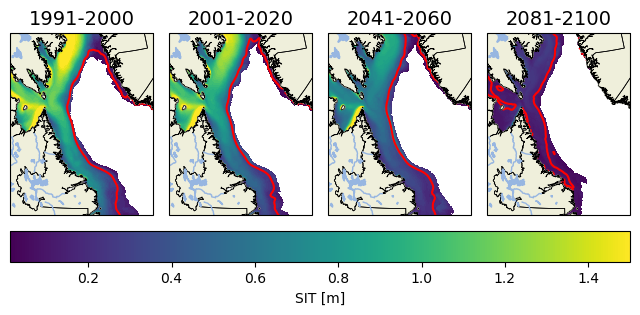

In [61]:
#=========sic_region==max========================
fig = plt.figure(figsize=(8,2.4))
sic_data = [model_sic_1991_00_, model_sic_2001_20_, model_sic_2041_60_, model_sic_2081_100_]

hi_data1 = [model_hi_1991_00b, model_hi_2001_20b, model_hi_2041_60b, model_hi_2081_100b]
titles = ['1991-2000', '2001-2020', '2041-2060', '2081-2100',]

global_min = np.min([np.nanmin(data.max('time').values) for data in hi_data1])
#global_max = np.max([np.nanmax(data.max('time').values) for data in hi_data1])
norm = plt.Normalize(vmin=global_min, vmax=1.5)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67
  
# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(sic_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(1,4, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=14)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
   
    ax.contourf(hi_data1[i].TLON, hi_data1[i].TLAT, hi_data1[i][2::12].mean('time'),levels=100,
                norm=norm, transform=ccrs.PlateCarree(), zorder=1)
    ax.contour(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
    #if i in [4,5]:
        #contf=ax.contourf(sic_data[i].lon, sic_data[i].lat, sic_data[i],
                          #levels=100, norm=norm, transform=ccrs.PlateCarree())
    
    
cbar_ax = fig.add_axes([0.125, -0.08, 0.775, 0.13])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='horizontal', label='SIT [m]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=14)  


plt.subplots_adjust(wspace=0.11)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig6a.jpg',dpi=500, bbox_inches='tight')
plt.show()

### Fig 6

In [62]:
hi_month_1990_2005=hi_hist_region.sel(time=slice('1990-01-01','2005-12-31'))
hi_month_2006_2020=hi_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
hi_region_1990_2020=xr.concat((hi_month_1990_2005,hi_month_2006_2020 ), dim='time')
hi_months=hi_region_1990_2020.groupby('time.month').mean('time')

In [63]:
#plot for article
sic_month_1990_2005 = aice_hist_region_.sel(time=slice('1990-01-01','2005-12-31'))
sic_month_2006_2020 = aice_proj_region_.sel(time=slice('2006-01-01','2020-12-31'))
sic_region_1990_2020= xr.concat([sic_month_1990_2005, sic_month_2006_2020], dim='time')
sic_months=sic_region_1990_2020.groupby('time.month').mean('time')

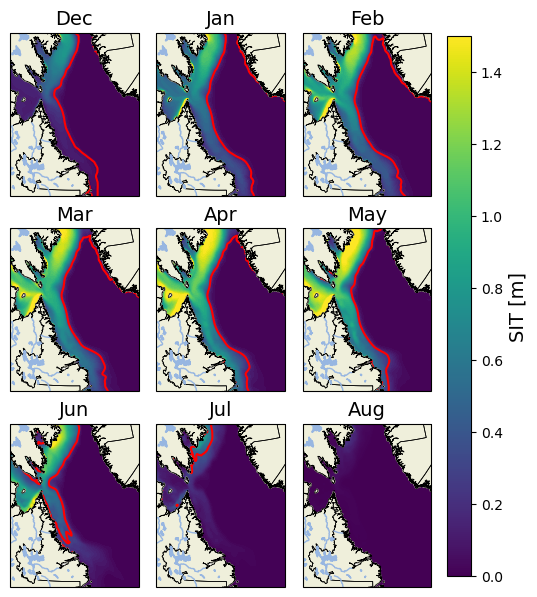

In [64]:
fig = plt.figure(figsize=(6, 7.2))

selected_data= [hi_months[11], hi_months[0], hi_months[1], hi_months[2], hi_months[3], hi_months[4], hi_months[5], hi_months[6],hi_months[7]]
selected_data1=[sic_months[11],sic_months[0],sic_months[1],sic_months[2],sic_months[3], sic_months[4], sic_months[5],sic_months[6],sic_months[7]]


titles = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']
#name=['a)','b)','c)','d)','e)','f)','g)','h)','i)']

global_min = np.min([np.nanmin(data.values) for data in selected_data])
global_max = np.max([np.nanmax(data.values) for data in selected_data])
norm = plt.Normalize(vmin=global_min, vmax=1.5)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67


# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(selected_data):
    ax = plt.subplot(3,3, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    
    ax.set_title(titles[i], fontsize=14)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    #ax.add_feature(cfeature.BORDERS,  zorder=2)
    
    
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,name[i], transform=ax.transAxes, fontsize=14)
    ax.contourf(selected_data[i].TLON, selected_data[i].TLAT, selected_data[i], levels=100, norm=norm,
                   transform=ccrs.PlateCarree(), )
    ax.contour(selected_data1[i].TLON, selected_data1[i].TLAT, selected_data1[i], levels=[15], norm=norm, colors='red',
               linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
    
cbar_ax = fig.add_axes([0.89, 0.125, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=14)  

plt.subplots_adjust(wspace=-0.15)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig7a.jpg',dpi=500, bbox_inches='tight')
plt.show()

### Fig 7

In [65]:
model_SIE_hist =aice_hist_region.sel(time=slice('1990-01-01','2005-12-31'))
model_SIE_proj =aice_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
model_SIE= xr.concat([model_SIE_hist, model_SIE_proj], dim='time')

obs_SIE=obs_CT_region.sel(time=slice('1990-01-01','2020-12-31'))

model_SIE_march=model_SIE[2::12].sum(('nj', 'ni'))
obs_SIE_march=obs_SIE[2::12].sum(['rlat','rlon'])

In [66]:
np.mean(model_SIE_march.values-obs_SIE_march.values)

-0.10454435602355082

# Plot of the obs and model from 1990 to 2018
fig, ax=plt.subplots(figsize=(10,4))
start_time=time.time()

ax.plot(np.arange(1990,2021), model_SIE_march, label='CESM1.3-HR', color='tab:blue', )
ax.plot(np.arange(1990,2021), obs_SIE_march, color='orange', label='CIS')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=14)
ax.set_ylim(0,1.3)
ax.legend()
ax.grid(alpha=0.15)
#plt.xlim(1990,2021)

plt.savefig('/storage2/tkyeimiah/Plots/Fig7-old.jpg',dpi=500, bbox_inches='tight') 
plt.show()


end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

### Fig 9

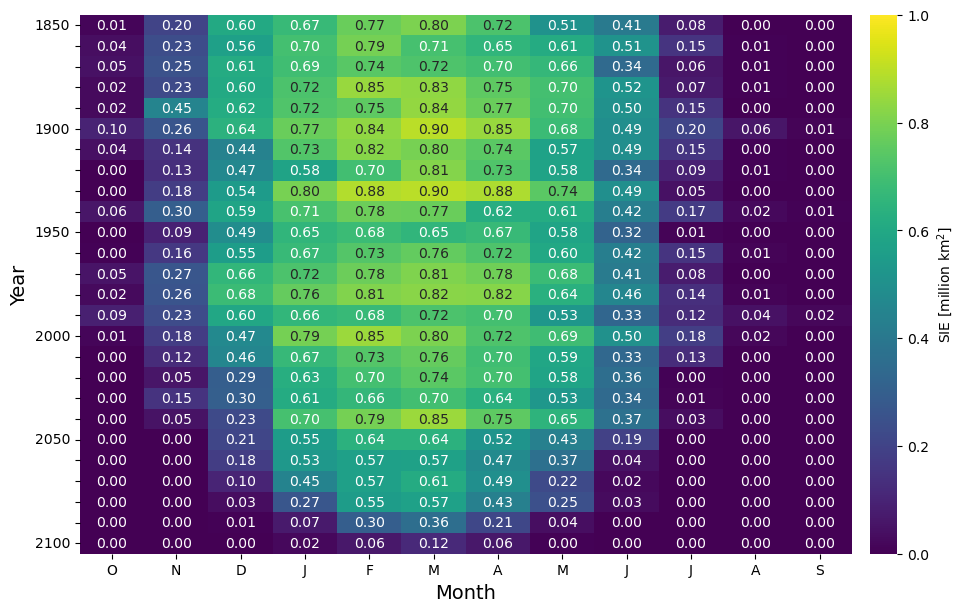

In [67]:
# Convert this DataArray to a DataFrame
aice1 = aice_hist_region.sel(time=slice('1850-01-01','2005-12-31'))
aice2 = aice_proj_region.sel(time=slice('2006-01-01','2100-12-31'))
aice3 = xr.concat([aice1, aice2], dim='time') 

ds_mean = aice3.sum(dim=['nj', 'ni'], skipna=True)
df = ds_mean.to_dataframe(name='SIE')

# Reset the index so that 'time' becomes a column
df.reset_index(inplace=True)

# Extract the year and month from the 'time' column
df['Year'] = [date.year for date in df['time']]
df['Month'] = [date.month for date in df['time']]

# Map numeric month to month name
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 
              6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 
              11: 'Nov', 12: 'Dec'}

df['Month'] = df['Month'].map(month_dict)

# Define custom sorting order for the months
custom_order = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar',
                'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']

# Convert 'month' to categorical data type with custom order
df['Month'] = pd.Categorical(df['Month'], categories=custom_order, ordered=True)

# Filter rows for the specified years
selected_years = np.arange(1850,2101,10)
df_all = df[df['Year'].isin(selected_years)]

# Create a pivot table with 'year' as rows, 'month' as columns, and mean 'aice' as values
pivot_df = df_all.pivot('Year', 'Month', 'SIE')

custom_order1 = ['O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S']

# Plot the heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(pivot_df,  cmap="viridis", annot=True, fmt='.2f', vmin=0, vmax=1, cbar=True,
            cbar_kws={'label':'SIE [million km$^2$]',
                      'pad':0.02})

plt.xticks(np.arange(0.5,12.5),custom_order1)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Year', fontsize=14)

# Specify the years you want to label
labelled_years = [1850, 1900, 1950, 2000, 2050, 2100]
# Create y-ticks for all years but set labels only for specified years
plt.yticks(np.arange(len(pivot_df.index)) + 0.5, 
           [str(year) if year in labelled_years else '' for year in pivot_df.index])
plt.ylabel('Year', fontsize=14)

#plt.savefig('/storage2/tkyeimiah/Plots/new-Fig9.jpg',dpi=500, bbox_inches='tight')
plt.savefig('/storage2/tkyeimiah/Plots/Fig7.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [68]:
# heat_map function

def heat_map(data, source):
    if source=='model':
        ds_mean = data.sum(dim=['nj', 'ni'], skipna=True)
        df = ds_mean.to_dataframe(name='SIE')
    elif source=='obs':
        ds_mean = data.sum(dim=['rlat', 'rlon'], skipna=True)
        df = ds_mean.to_dataframe(name='SIE')

    # Reset the index so that 'time' becomes a column
    df.reset_index(inplace=True)

    # Extract the year and month from the 'time' column
    df['Year'] = [date.year for date in df['time']]
    df['Month'] = [date.month for date in df['time']]

    # Map numeric month to month name
    month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                  7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

    df['Month'] = df['Month'].map(month_dict)
    
    # Define custom sorting order for the months
    custom_order = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar','Apr',
                    'May', 'Jun', 'Jul', 'Aug', 'Sep']

    # Convert 'month' to categorical data type with custom order
    df['Month'] = pd.Categorical(df['Month'], categories=custom_order, ordered=True)

    # Filter rows for the specified years
    selected_years = np.arange(1990,2021,3)
    df_all = df[df['Year'].isin(selected_years)]

    # Create a pivot table with 'year' as rows, 'month' as columns, and mean 'aice' as values
    pivot_df = df_all.pivot('Year', 'Month', 'SIE')
    return pivot_df

In [69]:
#using the function
model_SIE_pivot=heat_map(model_SIE, 'model')
obs_SIE_pivot=heat_map(obs_SIE, 'obs')

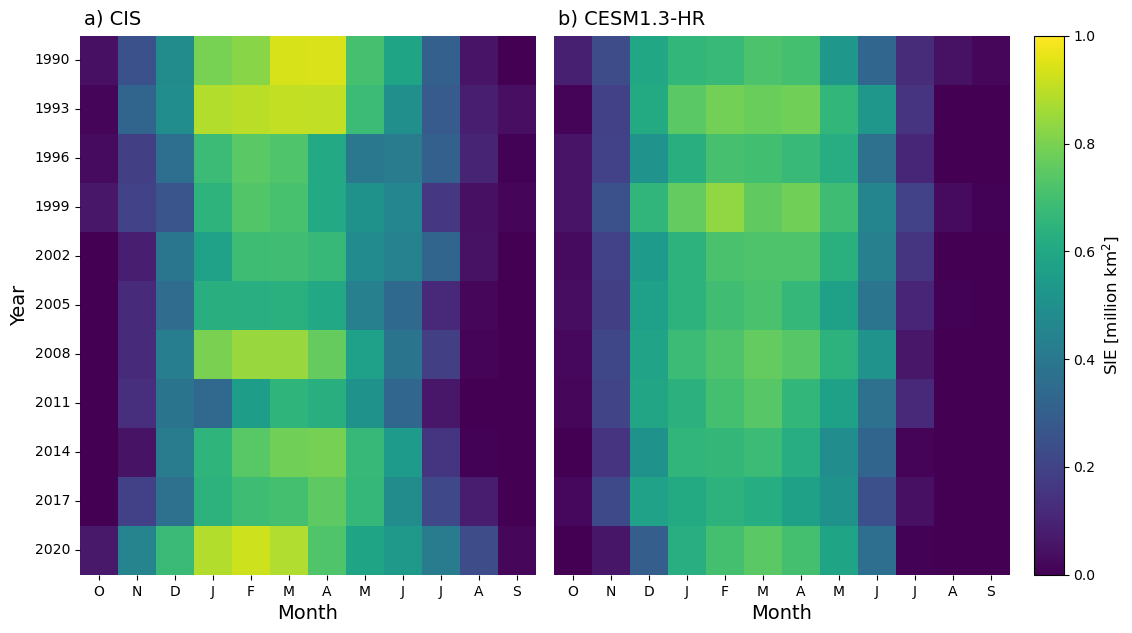

In [70]:
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,7),  gridspec_kw={'width_ratios':[1,1]}) #10-5

g1 = sns.heatmap(obs_SIE_pivot,  vmax=1.1, cmap="viridis", cbar=False, ax=ax1)
g1.set_ylabel('Year', fontsize=14)
g1.set_xlabel('Month', fontsize=14)
g1.text(0.01, 1.02, 'a) CIS',transform=ax1.transAxes,  fontsize=14)

custom_order1 = ['O', 'N', 'D', 'J', 'F', 'M','A',
                    'M', 'J', 'J', 'A', 'S']

g2 = sns.heatmap(model_SIE_pivot,  vmax=1,cbar=False, cmap="viridis", ax=ax2)
#colorbar = g2.collections[0].colorbar
#colorbar.ax.yaxis.label.set_size(13)  # Set the font size here
g2.set_ylabel('')
g2.set_xlabel('Month', fontsize=14)
g2.set_yticks([])
g2.text(0.01, 1.02, 'b) CESM1.3-HR',transform=ax2.transAxes, fontsize=14)

for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(custom_order1)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

axcb = fig.add_axes([0.92, 0.11, 0.025, 0.77])

# Create a colormap and a normalize object
cmap = sns.color_palette("viridis", as_cmap=True)
norm = mcolors.Normalize(vmin=0, vmax=1)

# Create the colorbar
cb1 = mcolorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical',)
cb1.set_label('SIE [million km$^2$]')
cb1.ax.yaxis.label.set_size(12)    
    
plt.subplots_adjust(wspace=0.04)  
plt.savefig('/storage2/tkyeimiah/Plots/Fig11.jpg',dpi=500, bbox_inches='tight')
plt.show()

### CDR

In [71]:
path_cdr='/storage2/tkyeimiah/CDR/'

In [72]:
cdr=xr.open_dataset(path_cdr+'CDR_CT.nc')
cdr

<xarray.Dataset>
Dimensions:                  (tdim: 372, x: 304, y: 448)
Coordinates:
  * tdim                     (tdim) datetime64[ns] 1990-01-01 ... 2020-12-01
  * x                        (x) float64 -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                        (y) float64 5.838e+06 5.812e+06 ... -5.338e+06
Data variables:
    cdr_seaice_conc_monthly  (tdim, y, x) float32 ...

In [73]:
cdr_CT=cdr.cdr_seaice_conc_monthly

In [74]:
# Extract the x and y grid coordinates
xgrid = cdr_CT.x.values
ygrid = cdr_CT.y.values

# Create a meshgrid of x and y coordinates
x, y = np.meshgrid(xgrid, ygrid)

# Define the projection used by the xgrid and ygrid (EPSG:3411)
proj_stereo = Proj(init='EPSG:3411')

# Define the projection for latitude and longitude
proj_latlon = Proj(proj='latlong', datum='WGS84')

# Transform the grid coordinates to latitude and longitude
lon, lat = transform(proj_stereo, proj_latlon, x, y)

# Create DataArrays for lon and lat to use xarray's slicing
lon_da = xr.DataArray(lon, dims=('y', 'x'))
lat_da = xr.DataArray(lat, dims=('y', 'x'))

# Define the Labrador coast boundaries
lon_min, lon_max = -73, -45  # Converted from 287 to 315 degrees to -73 to -45 degrees
lat_min, lat_max = 51, 69

# Subset the data using the domain mask
domain_mask = (lon_da >= lon_min) & (lon_da <= lon_max) & (lat_da >= lat_min) & (lat_da <= lat_max)
cdr_CT_subset = cdr_CT.where(domain_mask, drop=True)
cdr_CT_domain = cdr_CT_subset.where(cdr_CT_subset <= 1)
# Subset lon and lat accordingly
lon_subset = lon_da.where(domain_mask, drop=True)
lat_subset = lat_da.where(domain_mask, drop=True)

In [75]:
cdr_sic_1991_00 = cdr_CT_domain.sel(tdim=slice('1991', '2000'))
cdr_sic_2001_20 = cdr_CT_domain.sel(tdim=slice('2001', '2020'))
cdr_sic_1991_00_= cdr_sic_1991_00[2::12].mean('tdim')*100
cdr_sic_2001_20_= cdr_sic_2001_20[2::12].mean('tdim')*100

In [76]:
cdr_CT_sel=cdr_CT_domain.sel(tdim=slice('1990', '2020'))

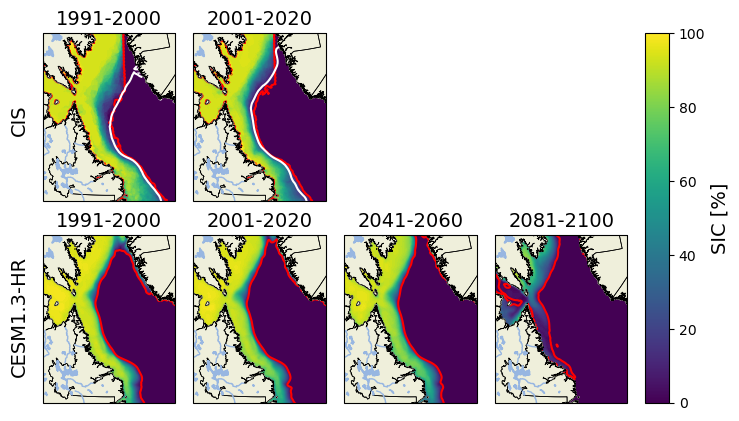

In [77]:
#=========sic_region==max========================

fig = plt.figure(figsize=(8,4.8))
sic_data = [cis_sic_1991_00_, cis_sic_2001_20_,
            model_sic_1991_00_, model_sic_2001_20_, model_sic_2041_60_, model_sic_2081_100_]
cdr_data = [cdr_sic_1991_00_, cdr_sic_2001_20_]
#hi_data1 = [model_hi_1991_00, model_hi_2000_20, model_hi_2040_60, model_hi_2080_100]
titles = ['1991-2000', '2001-2020', '1991-2000', '2001-2020', '2041-2060', '2081-2100' ]


norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
subplot_positions = [1, 2, 5, 6, 7, 8]
for i, v in enumerate(sic_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,4, subplot_positions[i],projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=14)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
    if i in [0,1]:
        contf=ax.contourf(sic_data[i].lon, sic_data[i].lat, sic_data[i],vmin=15,levels=100,
                           transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(sic_data[i].lon, sic_data[i].lat, sic_data[i], levels=[15], norm=norm, colors='red', 
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(lon_subset,lat_subset,cdr_data[i],levels=[15],norm=norm,colors='white',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
        
    if i in [2,3,4,5]:
        contf=ax.contourf(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i], vmin=15,
                          levels=100,transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
   
    
    
cbar_ax = fig.add_axes([0.9, 0.11, 0.03, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=14)  

name=['CIS','CESM1.3-HR']
x=[0.13,0.13]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=14)
plt.subplots_adjust(wspace=-0.1)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig3.jpg',dpi=500, bbox_inches='tight')
plt.show()


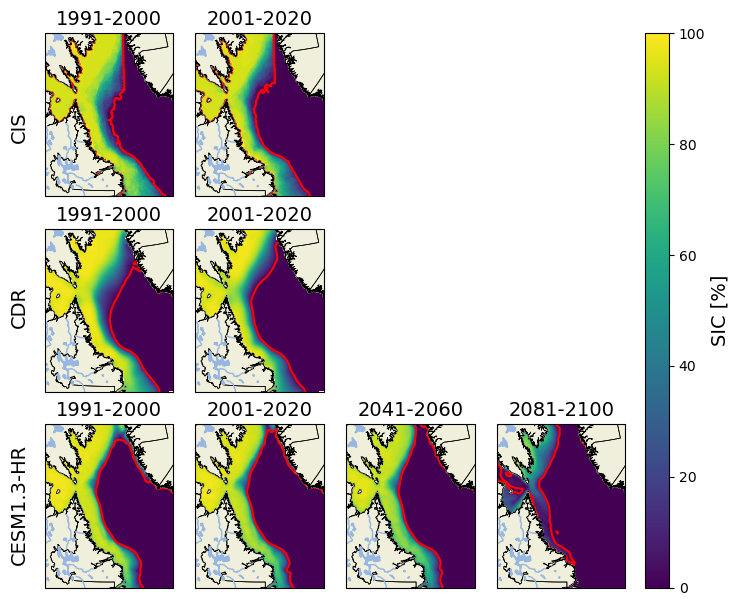

In [78]:
#=========sic_region==max========================

fig = plt.figure(figsize=(8,7.2))
sic_data = [cis_sic_1991_00_, cis_sic_2001_20_,cdr_sic_1991_00_, cdr_sic_2001_20_, 
            model_sic_1991_00_, model_sic_2001_20_, model_sic_2041_60_, model_sic_2081_100_]

#hi_data1 = [model_hi_1991_00, model_hi_2000_20, model_hi_2040_60, model_hi_2080_100]
titles = ['1991-2000', '2001-2020', '1991-2000', '2001-2020', '1991-2000', '2001-2020', '2041-2060', '2081-2100']


norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
subplot_positions = [1, 2, 5, 6, 9,10,11,12]
for i, v in enumerate(sic_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(3,4, subplot_positions[i],projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=14)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
    if i in [0,1]:
        contf=ax.contourf(sic_data[i].lon, sic_data[i].lat, sic_data[i],vmin=15,levels=100,
                           transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(sic_data[i].lon, sic_data[i].lat, sic_data[i], levels=[15], norm=norm, colors='red', 
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        
    if i in [2,3]:
        contf=ax.contourf(lon_subset,lat_subset,sic_data[i],vmin=15, levels=100,
                          transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(lon_subset,lat_subset,sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
        
    if i in [4,5,6,7]:
        contf=ax.contourf(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i], vmin=15,
                          levels=100,transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
    
   
    
    
cbar_ax = fig.add_axes([0.9, 0.11, 0.03, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=14)  

name=['CIS','CDR','CESM1.3-HR']
x=[0.13,0.13, 0.13]
y=[0.75,0.5, 0.225]
for i in range (3):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=14)
plt.subplots_adjust(wspace=-0.1)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/Fig10.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [79]:
obs_months=obs_CT_sel.groupby('time.month').mean('time')
obs_months2=obs_total_region.groupby('time.month').mean('time')
model_months=model_CT_sel.groupby('time.month').mean('time')
cdr_months=cdr_CT_sel.groupby('tdim.month').mean('tdim')

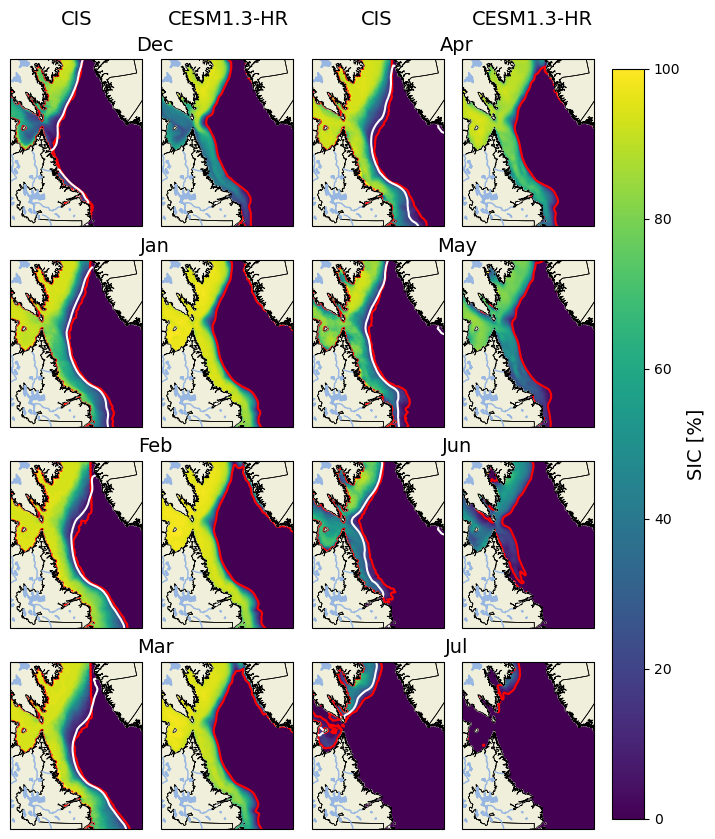

In [80]:

fig = plt.figure(figsize=(8,10))
obs_data=[obs_months[-1],obs_months[3], obs_months[0],obs_months[4], obs_months[1],obs_months[5],
          obs_months[2],obs_months[6]]

cdr_data=[cdr_months[-1],cdr_months[3], cdr_months[0],cdr_months[4], cdr_months[1],cdr_months[5],
          cdr_months[2],cdr_months[6]]

model_data=[model_months[-1],model_months[3], model_months[0],model_months[4], model_months[1],model_months[5],
            model_months[2],model_months[6]]

titles = ['Dec','Apr','Jan','May','Feb','Jun','Mar','Jul',]
#name=['a)','c)','e)','g)','i)','k)','m)','o)','q)']
#name1=['b)','d)','f)','h)','j)','l)','n)','p)','r)']

norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i in range(16):
    index = i // 2 
    
    if i % 2 == 0:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        ax.set_title(titles[index], fontsize=14, x=1.1)
        ax.add_feature(cfeature.LAND, zorder=2)
        ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
        ax.set_extent([x0, x1, y0, y1])
        ax.contourf(obs_data[index].lon, obs_data[index].lat, obs_data[index].fillna(0)*100, vmin=15,levels=100,
                    transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(obs_data[index].lon, obs_data[index].lat, obs_data[index].fillna(0)*100, levels=[15], norm=norm,  colors='red',
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(lon_subset,lat_subset, cdr_data[index]*100, levels=[15],  colors='white', norm=norm,
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        #ax.text(0,1.05,name[index], transform=ax.transAxes, fontsize=14)
        
    else:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        if index < len(model_data):
            #ax.set_title(titles[index], fontsize=14)
            ax.add_feature(cfeature.LAND, zorder=2)
            ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
            ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
            ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
            ax.set_extent([x0, x1, y0, y1])
            ax.contourf(model_data[index].TLON, model_data[index].TLAT, model_data[index], levels=100, 
                        vmin=15, transform=ccrs.PlateCarree(), zorder=1)
            ax.contour(model_data[index].TLON, model_data[index].TLAT, model_data[index], levels=[15], norm=norm, colors='red',
                       linewidth=5,transform=ccrs.PlateCarree(), zorder=1)
            
cbar_ax = fig.add_axes([0.9, 0.12, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=14)

name=['CIS', 'CESM1.3-HR','CIS', 'CESM1.3-HR']
x=[0.23, 0.42, 0.605, 0.8]
y=[0.91,0.91,0.91,0.91]
for i in range (4):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='horizontal',
             rotation_mode='anchor',fontsize=14)


plt.subplots_adjust(wspace=-0.1)
plt.savefig('/storage2/tkyeimiah/Plots/Fig3.jpg',dpi=500, bbox_inches='tight')
plt.show()



### PIOMAS

In [81]:
path_pio='/storage2/tkyeimiah/PIOMAS/PIOMAS'

In [82]:
piomas_data=xr.open_dataset(path_pio+'/heff.nc')
time = pd.date_range('1979-01-01', periods=540, freq='M')
piomas_data['time'] = time

In [83]:
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_pio = ((piomas_data.lat_scaler >= lat_min) & (piomas_data.lat_scaler<= lat_max) &
              (piomas_data.lon_scaler >= lon_min) & (piomas_data.lon_scaler <= lon_max))
piomas_data_region=piomas_data.where(mask_pio, drop=True)
piomas_data_region = piomas_data_region.where(piomas_data_region < 9999.9)

In [84]:
piomas_hi=piomas_data_region.heff

In [85]:
#plot for article
piomas_hi_1991_00 = piomas_hi.sel(time=slice('1991','2000'))
piomas_hi_2001_20 = piomas_hi.sel(time=slice('2001','2020'))

piomas_hi_1991_00_monthly = piomas_hi_1991_00.groupby('time.month').mean('time').mean(('y','x'))
piomas_hi_2001_20_monthly = piomas_hi_2001_20.groupby('time.month').mean('time').mean(('y','x'))

piomas_hi_1991_00_monmax = piomas_hi_1991_00.groupby('time.month').max('time').mean(('y','x'))
piomas_hi_2001_20_monmax = piomas_hi_2001_20.groupby('time.month').max('time').mean(('y','x'))

piomas_hi_1991_00_monmin = piomas_hi_1991_00.groupby('time.month').min('time').mean(('y','x'))
piomas_hi_2001_20_monmin = piomas_hi_2001_20.groupby('time.month').min('time').mean(('y','x'))

In [86]:
piomas_1990_2020=piomas_hi.sel(time=slice('1990','2020'))
piomas_hi_months=piomas_1990_2020.groupby('time.month').mean('time')

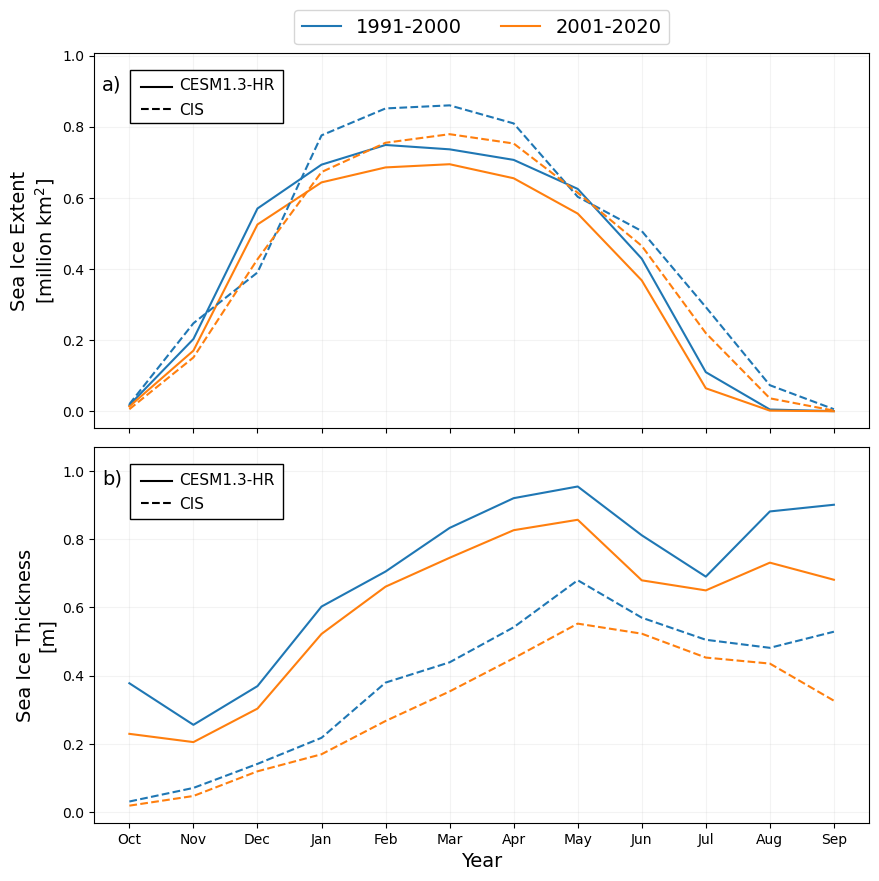

In [87]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

model_cis_dt = [model_1991_00_monthly, model_2001_20_monthly, cis_1991_00_monthly, cis_2001_20_monthly]
hi_dt = [model_hi_1991_00_monthly, model_hi_2001_20_monthly, cis_thick_1991_00_monthly*0.01, cis_thick_2001_20_monthly*0.01]

cl = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
month_dt = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
lb = ['1991-2000', '2001-2020']

# First plot
for i in range(len(model_cis_dt)):
    if i < 2:
        ls = '-'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i])
    if i >= 2:
        ls = '--'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i])

ax[0].set_ylabel('Sea Ice Extent\n[million km$^2$]', fontsize=14)
ax[0].grid(alpha=0.15)

# Adding lines and labels at the top of the first plot
for i in range(2):
    ax[0].plot([], [], color=cl[i], linestyle='-', label=lb[i])
    
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.14), ncol=2, fontsize=14)
#ax[0].legend(loc='upper right', fontsize=12)


# Second plot
for i in range(len(hi_dt)):
    if i < 2:
        ls = '-'
        ax[1].plot(month_dt, np.append(hi_dt[i][9:], hi_dt[i][:9]), linestyle=ls, color=cl[i])
    if i >= 2:
        ls = '--'
        ax[1].plot(month_dt, np.append(hi_dt[i][9:], hi_dt[i][:9]), linestyle=ls, color=cl[i])

ax[1].set_ylabel('Sea Ice Thickness\n[m]', fontsize=14)
ax[1].set_xlabel('Year', fontsize=14)
ax[1].grid(alpha=0.15)

# Add rectangles
rectangle = patches.Rectangle((0.005, 0.81), 2.4, 0.15, edgecolor='black', facecolor='white', linewidth=1, zorder=10)
ax[0].add_patch(rectangle)
#rectangle2 = patches.Rectangle((0.005, 0.46), 2, 0.09, edgecolor='black', facecolor='white', linewidth=1, zorder=10)
#ax[1].add_patch(rectangle2)
rectangle2 = patches.Rectangle((0.005, 0.86), 2.4, 0.16, edgecolor='black', facecolor='white', linewidth=1, zorder=10)
ax[1].add_patch(rectangle2)


# Add CESM1.3-HR text and line
ax[0].text(0.11, 0.9, 'CESM1.3-HR', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.91, 0.91], color='black', transform=ax[0].transAxes, linestyle='-', zorder=11)

# Add CIS text and dashed line
ax[0].text(0.11, 0.835, 'CIS', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.85, 0.85], color='black', transform=ax[0].transAxes, linestyle='--', zorder=11)

# Add CESM1.3-HR text and line
ax[1].text(0.11, 0.9, 'CESM1.3-HR', transform=ax[1].transAxes, fontsize=11, zorder=11)
ax[1].plot([0.06, 0.1], [0.91, 0.91], color='black', transform=ax[1].transAxes, linestyle='-', zorder=11)

# Add PIOMAS text and dashed line
ax[1].text(0.11, 0.835, 'CIS', transform=ax[1].transAxes, fontsize=11, zorder=11)
ax[1].plot([0.06, 0.1], [0.85, 0.85], color='black', transform=ax[1].transAxes, linestyle='--', zorder=11)

ax[0].text(0.01, 0.9, 'a)', transform=ax[0].transAxes,  fontsize=14)
ax[1].text(0.01, 0.9, 'b)', transform=ax[1].transAxes,  fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/Fig2.jpg', dpi=500, bbox_inches='tight')
plt.show()


In [88]:
cis_thick_1991_00[8::12]

<xarray.DataArray (time: 10, rlat: 206, rlon: 181)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * rlon     (rlon) float64 4.15 4.25 4.35 4.45 4.55 ... 21.85 21.95 22.05 22.15
  * rlat     (rlat) float64 -12.95 -12.85 -12.75 -12.65 ... 7.25 7.35 7.45 7.55
    lon      (rlat, rlon) float64 -74.43 -74.28 -74.12 ... -28.43 -28.26 -28.09
    lat      (rlat, rlon) float64 51.09 51.08 51.08 51.08 ... 64.19 64.12 64.05
  * time     (time) datetime64[ns] 1991-09-30 1992-09-30 ... 2000-09-30

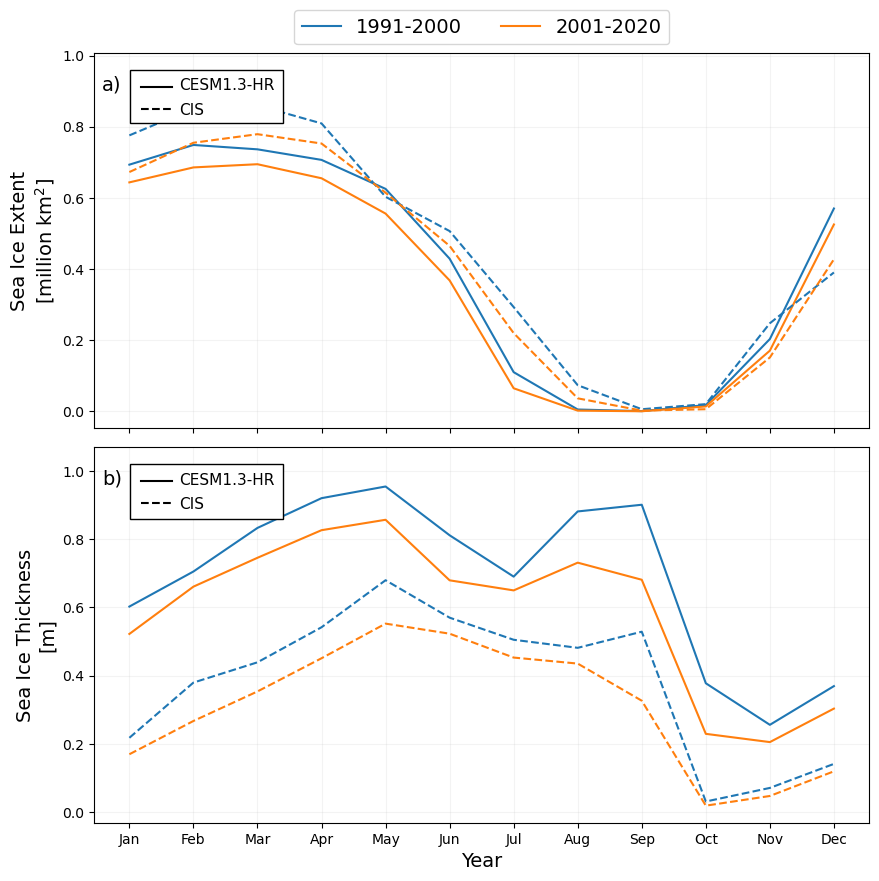

In [89]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

model_cis_dt = [model_1991_00_monthly, model_2001_20_monthly, cis_1991_00_monthly, cis_2001_20_monthly]
hi_dt = [model_hi_1991_00_monthly, model_hi_2001_20_monthly, cis_thick_1991_00_monthly*0.01, cis_thick_2001_20_monthly*0.01]

cl = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
month_dt = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
lb = ['1991-2000', '2001-2020']

# First plot
for i in range(len(model_cis_dt)):
    if i < 2:
        ls = '-'
        ax[0].plot(month_dt, model_cis_dt[i], linestyle=ls, color=cl[i])
    if i >= 2:
        ls = '--'
        ax[0].plot(month_dt, model_cis_dt[i], linestyle=ls, color=cl[i])

ax[0].set_ylabel('Sea Ice Extent\n[million km$^2$]', fontsize=14)
ax[0].grid(alpha=0.15)

# Adding lines and labels at the top of the first plot
for i in range(2):
    ax[0].plot([], [], color=cl[i], linestyle='-', label=lb[i])
    
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.14), ncol=2, fontsize=14)
#ax[0].legend(loc='upper right', fontsize=12)


# Second plot
for i in range(len(hi_dt)):
    if i < 2:
        ls = '-'
        ax[1].plot(month_dt, hi_dt[i], linestyle=ls, color=cl[i])
    if i >= 2:
        ls = '--'
        ax[1].plot(month_dt, hi_dt[i], linestyle=ls, color=cl[i])

ax[1].set_ylabel('Sea Ice Thickness\n[m]', fontsize=14)
ax[1].set_xlabel('Year', fontsize=14)
ax[1].grid(alpha=0.15)

# Add rectangles
rectangle = patches.Rectangle((0.005, 0.81), 2.4, 0.15, edgecolor='black', facecolor='white', linewidth=1, zorder=10)
ax[0].add_patch(rectangle)
#rectangle2 = patches.Rectangle((0.005, 0.46), 2, 0.09, edgecolor='black', facecolor='white', linewidth=1, zorder=10)
#ax[1].add_patch(rectangle2)
rectangle2 = patches.Rectangle((0.005, 0.86), 2.4, 0.16, edgecolor='black', facecolor='white', linewidth=1, zorder=10)
ax[1].add_patch(rectangle2)


# Add CESM1.3-HR text and line
ax[0].text(0.11, 0.9, 'CESM1.3-HR', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.91, 0.91], color='black', transform=ax[0].transAxes, linestyle='-', zorder=11)

# Add CIS text and dashed line
ax[0].text(0.11, 0.835, 'CIS', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.85, 0.85], color='black', transform=ax[0].transAxes, linestyle='--', zorder=11)

# Add CESM1.3-HR text and line
ax[1].text(0.11, 0.9, 'CESM1.3-HR', transform=ax[1].transAxes, fontsize=11, zorder=11)
ax[1].plot([0.06, 0.1], [0.91, 0.91], color='black', transform=ax[1].transAxes, linestyle='-', zorder=11)

# Add PIOMAS text and dashed line
ax[1].text(0.11, 0.835, 'CIS', transform=ax[1].transAxes, fontsize=11, zorder=11)
ax[1].plot([0.06, 0.1], [0.85, 0.85], color='black', transform=ax[1].transAxes, linestyle='--', zorder=11)

ax[0].text(0.01, 0.9, 'a)', transform=ax[0].transAxes,  fontsize=14)
ax[1].text(0.01, 0.9, 'b)', transform=ax[1].transAxes,  fontsize=14)

plt.subplots_adjust(hspace=0.05)
#plt.savefig('/storage2/tkyeimiah/Plots/Fig2.jpg', dpi=500, bbox_inches='tight')
plt.show()


In [90]:
model_hi_1991_00_sep=model_hi_1991_00b[8::12].mean('time')
model_hi_2001_20_sep=model_hi_2001_20b[8::12].mean('time')
model_hi_1991_00_oct=model_hi_1991_00b[9::12].mean('time')
model_hi_2001_20_oct=model_hi_2001_20b[9::12].mean('time')

cis_hi_1991_00_sep=cis_thick_1991_00[8::12].mean('time')*0.01
cis_hi_2001_20_sep=cis_thick_2001_20[8::12].mean('time')*0.01
cis_hi_1991_00_oct=cis_thick_1991_00[9::12].mean('time')*0.01
cis_hi_2001_20_oct=cis_thick_2001_20[9::12].mean('time')*0.01

In [103]:
np.nanmean(model_hi_2001_20_sep.values)

0.6812341

In [104]:
np.nanmean(model_hi_2001_20_oct.values)

0.2295598

In [93]:
model_hi_1991_00_mm = model_hi_1991_00b.groupby('time.month').mean('time')
model_hi_2001_20_mm = model_hi_2001_20b.groupby('time.month').mean('time')

cis_thick_1991_00_mm = cis_thick_1991_00.groupby('time.month').mean('time')
cis_thick_2001_20_mm = cis_thick_2001_20.groupby('time.month').mean('time')

In [94]:
np.nanmean(model_hi_1991_00_mm[8])

0.90109605

In [115]:
model_hi_1991_00_sep.fillna(0).plot()

In [ ]:
cmap = plt.get_cmap('bwr', 15)
            norm = norm_second_row
            contour = ax.pcolormesh(data[i].lon, data[i].lat, data[i], 
                                     cmap=cmap, norm=norm, transform=ccrs.PlateCarree())


In [151]:
data = [cis_hi_1991_00_sep, cis_hi_1991_00_oct, cis_hi_2001_20_sep, cis_hi_2001_20_oct]
titles = ['September\n1991-2000', 'October\n1991-2000', '2001-2020', '2001-2020']

fig = plt.figure(figsize=(8, 9.6))

norm = plt.Normalize(vmin=0, vmax=2)
cb = cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 = -68, -48, 51, 67
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2

# Define the colormap


for i, v in enumerate(data):
    ax = plt.subplot(2, 2, i + 1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                  central_latitude=c_lat, standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=11)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    
    # Plot data using pcolormesh
    cmap = plt.get_cmap('viridis', 15)
    mesh = ax.pcolormesh(v.lon, v.lat, v, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

cbar_ax = fig.add_axes([0.9, 0.11, 0.045, 0.77])
cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='vertical', label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=14)

plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.savefig('/storage2/tkyeimiah/Plots/cis_sept-oct.jpg',dpi=500, bbox_inches='tight')
plt.show()

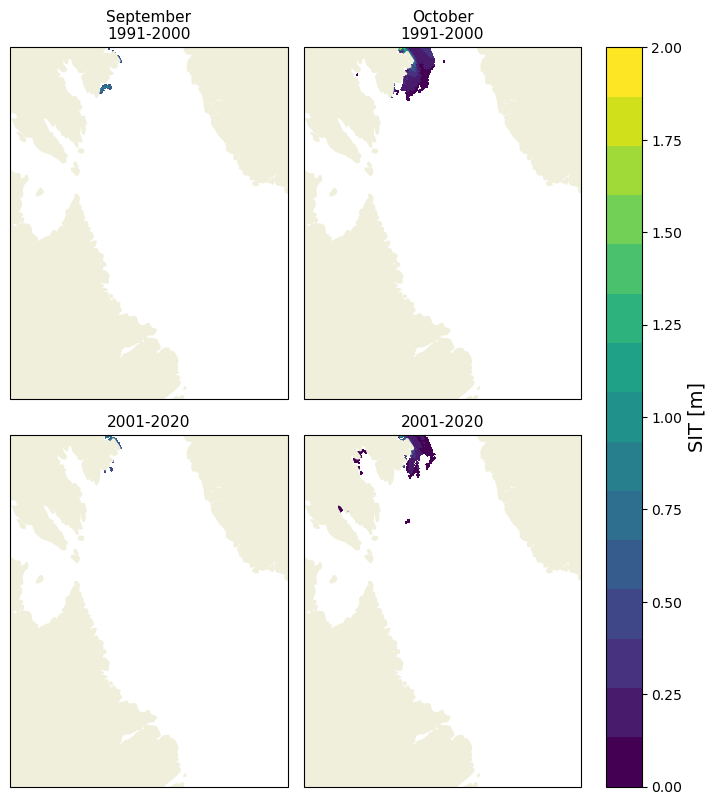

In [152]:
data = [model_hi_1991_00_sep, model_hi_1991_00_oct, model_hi_2001_20_sep, model_hi_2001_20_oct]
titles = ['September\n1991-2000', 'October\n1991-2000', '2001-2020', '2001-2020']

fig = plt.figure(figsize=(8, 9.6))

norm = plt.Normalize(vmin=0, vmax=2)
cb = cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 = -68, -48, 51, 67
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2

# Define the colormap


for i, v in enumerate(data):
    ax = plt.subplot(2, 2, i + 1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                  central_latitude=c_lat, standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=11)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    
    # Plot data using pcolormesh
    cmap = plt.get_cmap('viridis', 15)
    mesh = ax.pcolormesh(v.TLON, v.TLAT, v, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

cbar_ax = fig.add_axes([0.9, 0.11, 0.045, 0.77])
cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='vertical', label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=14)

plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.savefig('/storage2/tkyeimiah/Plots/model_sept-oct.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
data_list= [cis_hi_1991_00_sep, cis_hi_1991_00_oct, cis_hi_2001_20_sep, cis_hi_2001_20_oct,
            model_hi_1991_00_sep, model_hi_1991_00_oct, model_hi_2001_20_sep, model_hi_2001_20_oct]

In [160]:
def nan_val (data):
    flattened_values = data.values.flatten()

    # Filter out NaN values
    non_nan_values = flattened_values[~np.isnan(flattened_values)]

    # return non-NaN values'
    return non_nan_values

In [161]:
cis_hi_1991_00_sep_values= nan_val(cis_hi_1991_00_sep)
cis_hi_1991_00_oct_values= nan_val(cis_hi_1991_00_oct)
cis_hi_2001_20_sep_values= nan_val(cis_hi_2001_20_sep)
cis_hi_2001_20_oct_values= nan_val(cis_hi_2001_20_oct)

model_hi_1991_00_sep_values= nan_val(model_hi_1991_00_sep)
model_hi_1991_00_oct_values= nan_val(model_hi_1991_00_oct)
model_hi_2001_20_sep_values= nan_val(model_hi_2001_20_sep)
model_hi_2001_20_oct_values= nan_val(model_hi_2001_20_oct)

In [187]:
print(len(cis_hi_1991_00_sep_values))
print(len(cis_hi_1991_00_oct_values))
print(len(cis_hi_2001_20_sep_values))
print(len(cis_hi_2001_20_oct_values))

print(len(model_hi_1991_00_sep_values))
print(len(model_hi_1991_00_oct_values))
print(len(model_hi_2001_20_sep_values))
print(len(model_hi_2001_20_oct_values))

41
485
77
177
259
2184
190
2009


In [188]:
print(np.mean(cis_hi_1991_00_sep_values))
print(np.mean(cis_hi_1991_00_oct_values))
print(np.mean(cis_hi_2001_20_sep_values))
print(np.mean(cis_hi_2001_20_oct_values))

print(np.mean(model_hi_1991_00_sep_values))
print(np.mean(model_hi_1991_00_oct_values))
print(np.mean(model_hi_2001_20_sep_values))
print(np.mean(model_hi_2001_20_oct_values))

0.52895427
0.0312104
0.326671
0.019069646
0.90109605
0.37782988
0.681234
0.22955978


In [182]:
from docx import Document

# Initialize a new Word document
doc = Document()
# Example data arrays

# Adding data to the document
doc.add_heading('cis_hi_1991_00_sep_values', level=1)
doc.add_paragraph(', '.join(map(str, cis_hi_1991_00_sep_values)))

doc.add_heading('cis_hi_1991_00_oct_values', level=1)
doc.add_paragraph(', '.join(map(str, cis_hi_1991_00_oct_values)))

doc.add_heading('cis_hi_2001_20_sep_values', level=1)
doc.add_paragraph(', '.join(map(str, cis_hi_2001_20_sep_values)))

doc.add_heading('cis_hi_2001_20_oct_values', level=1)
doc.add_paragraph(', '.join(map(str, cis_hi_2001_20_oct_values)))

doc.add_heading('model_hi_1991_00_sep_values', level=1)
doc.add_paragraph(', '.join(map(str, model_hi_1991_00_sep_values)))

doc.add_heading('model_hi_1991_00_oct_values', level=1)
doc.add_paragraph(', '.join(map(str, model_hi_1991_00_oct_values)))

doc.add_heading('model_hi_2001_20_sep_values', level=1)
doc.add_paragraph(', '.join(map(str, model_hi_2001_20_sep_values)))

doc.add_heading('model_hi_2001_20_oct_values', level=1)
doc.add_paragraph(', '.join(map(str, model_hi_2001_20_oct_values)))

doc.save('/storage2/tkyeimiah/Plots/word.docx')

In [91]:
# SIE  : CESM1.3-HR
march_aice_hist = aice_hist_region.sel(time=slice('1850','2005'))[2::12].sum(('nj', 'ni'))
march_aice_proj = aice_proj_region.sel(time=slice('2006','2100'))[2::12].sum(('nj', 'ni'))
march_aice=xr.concat([march_aice_hist,march_aice_proj], dim='time')

# SIE : CIS
obs_SIE=obs_CT_region.sel(time=slice('1990','2020'))
obs_SIE_march=obs_SIE[2::12].sum(['rlat','rlon'])

# SIT : CESM1.3-HR
march_hi_hist = hi_hist_region1.sel(time=slice('1850','2005'))[2::12].mean(('nj', 'ni'))
march_hi_proj = hi_proj_region1.sel(time=slice('2006','2100'))[2::12].mean(('nj', 'ni'))
march_hi=xr.concat([march_hi_hist,march_hi_proj], dim='time')

# SIT : PIOMAS
march_piomas_hi = piomas_hi[2::12].mean(('y', 'x'))


fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
years =np.arange(1850,2101,1)
#yearss =np.arange(1850,2101)
#ax[2]=ax[1].twinx()
# First plot              
ax[0].plot(years, march_aice, label='CESM1.3-HR')
ax[0].plot(np.arange(1990,2021), obs_SIE_march, color='red', label='CIS')
ax[0].set_ylabel('Sea Ice Extent\n[million km$^2$]', fontsize=14)
ax[0].grid(alpha=0.15)     
ax[0].legend(loc='lower left')
ax[0].set_xlim(1850, 2101)
# Second plot         
ax[1].plot(years, march_hi, label='CESM1.3-HR')
#ax[1].plot(np.arange(1979,2024), march_piomas_hi, color='red', label='PIOMAS')
#ax[2].plot(ice_season_days_df['Year'],ice_season_days_df['Days Above 0.3m'])
ax[1].set_ylabel('Sea Ice Thickness\n[m]', fontsize=14)
ax[1].grid(alpha=0.15)
ax[1].legend(loc='lower left') 
#
ax[1].set_xlabel('Year', fontsize=14)

ax[0].text(0.01, 0.9, 'a)',transform=ax[0].transAxes,  fontsize=14)
ax[1].text(0.01, 0.9, 'b)',transform=ax[1].transAxes,  fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/new-Fig2.jpg', dpi=500, bbox_inches='tight')
plt.show()

In [92]:
#=========sic_region==max========================

fig = plt.figure(figsize=(8,4.8))

#sic_data = [model_sic_1991_00_, model_sic_2001_20_,model_sic_1991_00_, model_sic_2001_20_, model_sic_2041_60_, model_sic_2081_100_]

hi_data1 = [cis_thick_1991_00a*0.01, cis_thick_2001_20a*0.01,
            model_hi_1991_00, model_hi_2001_20, model_hi_2041_60, model_hi_2081_100]
titles = ['1991-2000', '2001-2020', '1991-2000', '2001-2020', '2041-2060', '2081-2100' ]

global_min = np.min([np.nanmin(data.max('time').values) for data in hi_data1])
#global_max = np.max([np.nanmax(data.max('time').values) for data in hi_data1])
norm = plt.Normalize(vmin=global_min, vmax=1.5)
norm2= plt.Normalize(vmin=global_min, vmax=1.5)
norm1= plt.Normalize(vmin=global_min, vmax=1.5)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
subplot_positions = [1, 2, 5, 6, 7, 8]
for i, v in enumerate(hi_data1):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,4, subplot_positions[i],projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=14)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
    if i in [0,1]:
        contf=ax.contourf(hi_data1[i].lon, hi_data1[i].lat,hi_data1[i][4::12].mean('time').fillna(0),
                          norm=norm1, levels=100, transform=ccrs.PlateCarree(), zorder=1)
        #ax.contour(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               #transform=ccrs.PlateCarree(), zorder=1)
        
    if i in [2,3,4,5]:
        contf=ax.contourf(hi_data1[i].TLON, hi_data1[i].TLAT, hi_data1[i][4::12].mean('time'),levels=100,
                          norm=norm2, transform=ccrs.PlateCarree(), zorder=1)
        #ax.contour(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               #transform=ccrs.PlateCarree(), zorder=1)
   
    
    
cbar_ax = fig.add_axes([0.9, 0.11, 0.03, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=14)  

name=['CIS','CESM1.3-HR']
x=[0.13,0.13]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=14)
plt.subplots_adjust(wspace=-0.1)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/Fig12.jpg',dpi=500, bbox_inches='tight')
plt.show()



In [93]:
obs_thick_months.lon

<xarray.DataArray 'lon' (rlat: 206, rlon: 181)>
array([[-74.43481445, -74.27972412, -74.12469482, ..., -48.61526489,
        -48.48648071, -48.35794067],
       [-74.42993164, -74.2744751 , -74.11904907, ..., -48.55233765,
        -48.42330933, -48.29455566],
       [-74.42504883, -74.26919556, -74.1133728 , ..., -48.48919678,
        -48.35995483, -48.23098755],
       ...,
       [-72.53833008, -72.22854614, -71.91900635, ..., -28.73452759,
        -28.56658936, -28.39944458],
       [-72.51947021, -72.2081604 , -71.89709473, ..., -28.58117676,
        -28.41320801, -28.2460022 ],
       [-72.50042725, -72.18756104, -71.87496948, ..., -28.42700195,
        -28.25900269, -28.09179688]])
Coordinates:
  * rlon     (rlon) float64 4.15 4.25 4.35 4.45 4.55 ... 21.85 21.95 22.05 22.15
  * rlat     (rlat) float64 -12.95 -12.85 -12.75 -12.65 ... 7.25 7.35 7.45 7.55
    lon      (rlat, rlon) float64 -74.43 -74.28 -74.12 ... -28.43 -28.26 -28.09
    lat      (rlat, rlon) float64 51.09 51.08 51.08 51.08 ... 64.19 64.12 64.05
Attributes:
    units:          degrees_east
    long_name:      longitude
    standard_name:  longitude
    actual_range:   [-170.91793823   16.40908432]

In [94]:
fig = plt.figure(figsize=(8,10))
thick_data=[obs_thick_months[-1],obs_thick_months[3],obs_thick_months[0],obs_thick_months[4],
          obs_thick_months[1],obs_thick_months[5],obs_thick_months[2],obs_thick_months[6]]

model_data=[hi_months[-1], hi_months[3], hi_months[0], hi_months[4], hi_months[1], hi_months[5],
            hi_months[2], hi_months[6]]

obs_data1=[obs_months[-1],obs_months[3], obs_months[0],obs_months[4], obs_months[1],obs_months[5],
          obs_months[2],obs_months[6]]

obs_data2=[obs_months2[-1],obs_months2[3], obs_months2[0],obs_months2[4], obs_months2[1],obs_months2[5],
          obs_months2[2],obs_months2[6]]




titles = ['Dec','Apr','Jan','May','Feb','Jun','Mar','Jul',]
#name=['a)','c)','e)','g)','i)','k)','m)','o)','q)']
#name1=['b)','d)','f)','h)','j)','l)','n)','p)','r)']

norm = plt.Normalize(vmin=0, vmax=1.5)
#norm2= plt.Normalize(vmin=0, vmax=1.7)
norm1= plt.Normalize(vmin=0, vmax=1.7)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i in range(16):
    index = i // 2 
    
    if i % 2 == 0:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        ax.set_title(titles[index], fontsize=14, x=1.1)
        ax.add_feature(cfeature.LAND, zorder=2)
        ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
        ax.set_extent([x0, x1, y0, y1])
        ax.contourf(thick_data[index].lon, thick_data[index].lat, thick_data[index].fillna(0)*0.01,levels=100, norm=norm1,
                    transform=ccrs.PlateCarree())
        ax.contour(obs_data1[index].lon, obs_data1[index].lat, obs_data1[index].fillna(0)*100, levels=[15], norm=norm,  colors='red',
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(obs_data2[index].lon, obs_data2[index].lat, obs_data2[index].fillna(0)*100, levels=[15], norm=norm,  colors='white',
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        
    else:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        if index < len(model_data):
            #ax.set_title(titles[index], fontsize=14)
            ax.add_feature(cfeature.LAND, zorder=2)
            ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
            ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
            ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
            ax.set_extent([x0, x1, y0, y1])
            ax.contourf(model_data[index].TLON, model_data[index].TLAT, model_data[index],levels=100, norm=norm,
                        transform=ccrs.PlateCarree(), zorder=1)

cbar_ax = fig.add_axes([0.9, 0.12, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIT [m]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=14)

name=['CIS', 'CESM1.3-HR', ' CIS', 'CESM1.3-HR']
x=[0.23, 0.42, 0.605, 0.8]
y=[0.91,0.91,0.91,0.91]
for i in range (4):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='horizontal',
             rotation_mode='anchor',fontsize=14)


plt.subplots_adjust(wspace=-0.1)
plt.savefig('/storage2/tkyeimiah/Plots/Fig4.jpg',dpi=500, bbox_inches='tight')
plt.show()

### LANDFAST

In [95]:
path = '/storage2/tkyeimiah'

uvel_dh = xr.open_dataset(path+'/iHESP/EM1/HR-hist/uvel_hist/uvel_hist.nc')
uvel_dp = xr.open_dataset(path+'/iHESP/EM1/HR-proj/uvel_proj/uvel_proj.nc')


vvel_dh = xr.open_dataset(path+'/iHESP/EM1/HR-hist/vvel_hist/vvel_hist.nc')
vvel_dp = xr.open_dataset(path+'/iHESP/EM1/HR-proj/vvel_proj/vvel_proj.nc')

In [96]:
uvel_hist=shift_month(uvel_dh['uvel'])
uvel_proj=shift_month(uvel_dp['uvel'])

vvel_hist=shift_month(vvel_dh['vvel'])
vvel_proj=shift_month(vvel_dp['vvel'])

In [97]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69


# Create a mask for Labrador coast 
mask_uvel_hist = ((uvel_hist.TLAT >= lat_min) & (uvel_hist.TLAT <= lat_max) &
        (uvel_hist.TLON >= lon_min) & (uvel_hist.TLON <= lon_max))

mask_uvel_proj = ((uvel_proj.TLAT >= lat_min) & (uvel_proj.TLAT <= lat_max) &
        (uvel_proj.TLON >= lon_min) & (uvel_proj.TLON <= lon_max))

mask_vvel_hist = ((vvel_hist.TLAT >= lat_min) & (vvel_hist.TLAT <= lat_max) &
        (vvel_hist.TLON >= lon_min) & (vvel_hist.TLON <= lon_max))

mask_vvel_proj = ((vvel_proj.TLAT >= lat_min) & (vvel_proj.TLAT <= lat_max) & 
        (vvel_proj.TLON >= lon_min) & (vvel_proj.TLON <= lon_max))

# Apply the mask to the aice variable
uvel_hist_region_ =uvel_hist.where(mask_uvel_hist, drop=True)
uvel_proj_region_ =uvel_proj.where(mask_uvel_proj, drop=True)
vvel_hist_region_ =vvel_hist.where(mask_vvel_hist, drop=True)
vvel_proj_region_ =vvel_proj.where(mask_vvel_proj, drop=True)

In [98]:
# Function for landfast ice
def landfast_ice(uvel,vvel,conc,threshold):
    # Calculate the magnitude of the velocity
    velocity_magnitude = np.sqrt(uvel**2 + vvel**2)

    # Define a threshold for landfast ice 
    velocity_threshold = threshold  # 5*10^-4m/s == 0.05cm/s /// 4cm/s

    # Define a threshold for sea ice concentration to ensure ice presence
    concentration_threshold = 90 # 90%

    # Create a mask for where the velocity magnitude is less than the threshold
    landfast_mask = (velocity_magnitude <= velocity_threshold) &  (conc >= concentration_threshold)
    
    # Apply the mask to the sea ice concentration
    landfast_ice_concentration = conc.where(landfast_mask)
    
    return landfast_ice_concentration

In [99]:
#0.5cm
model_fastIce_hist_05_=landfast_ice(uvel_hist_region_, vvel_hist_region_, aice_hist_region_, 0.1).sel(time=slice('1850','2005'))
model_fastIce_proj_05_=landfast_ice(uvel_proj_region_, vvel_proj_region_, aice_proj_region_, 0.1).sel(time=slice('2006','2100'))
model_fastIce = xr.concat([model_fastIce_hist_05_, model_fastIce_proj_05_], dim='time')

####################
model_fastIce_hist_05 = (model_fastIce_hist_05_ * tarea_hist_region_)
model_fastIce_proj_05 = (model_fastIce_proj_05_ * tarea_proj_region_)
model_fastIce_05 = xr.concat([model_fastIce_hist_05, model_fastIce_proj_05], dim='time')

In [100]:
lon_min, lon_max =296, 299 #73W & 45W
lat_min, lat_max =58,60
#sat:298.4,298.5 #tak:298.5,298.6
#sat:56.46,56.46 #tak:56.41,56.42

# Create a mask for Labrador coast 
mask_u = ((model_fastIce.TLAT >= lat_min) & (model_fastIce.TLAT <= lat_max) &
        (model_fastIce.TLON >= lon_min) & (model_fastIce.TLON <= lon_max))
model_fastIcee=model_fastIce.where(mask_u, drop=True)
#model_fastIce[0].plot()

In [101]:
lon_min, lon_max =296, 299 #73W & 45W
lat_min, lat_max =58,60

# Create a mask for Labrador coast 
mask_pu = ((piomas_data.lat_scaler >= lat_min) & (piomas_data.lat_scaler<= lat_max) &
              (piomas_data.lon_scaler >= lon_min) & (piomas_data.lon_scaler <= lon_max))
piomas_data_=piomas_data.where(mask_pu, drop=True)
piomas_data_region1 = piomas_data_.where(piomas_data_ < 9999.9)

In [102]:
lat_min, lat_max =58,60
lon_min, lon_max =-64, -61

# Create a mask for Labrador coast 
maskobs_tu = ((obs_thick_region1.lat>= lat_min) & (obs_thick_region1.lat <= lat_max) & (obs_thick_region1.lon >= lon_min) & (obs_thick_region1.lon<= lon_max))
obs_thick_region2=obs_thick_region1.where(maskobs_tu, drop=True)

In [103]:
np.nanmax(model_fastIcee.values)

99.907845

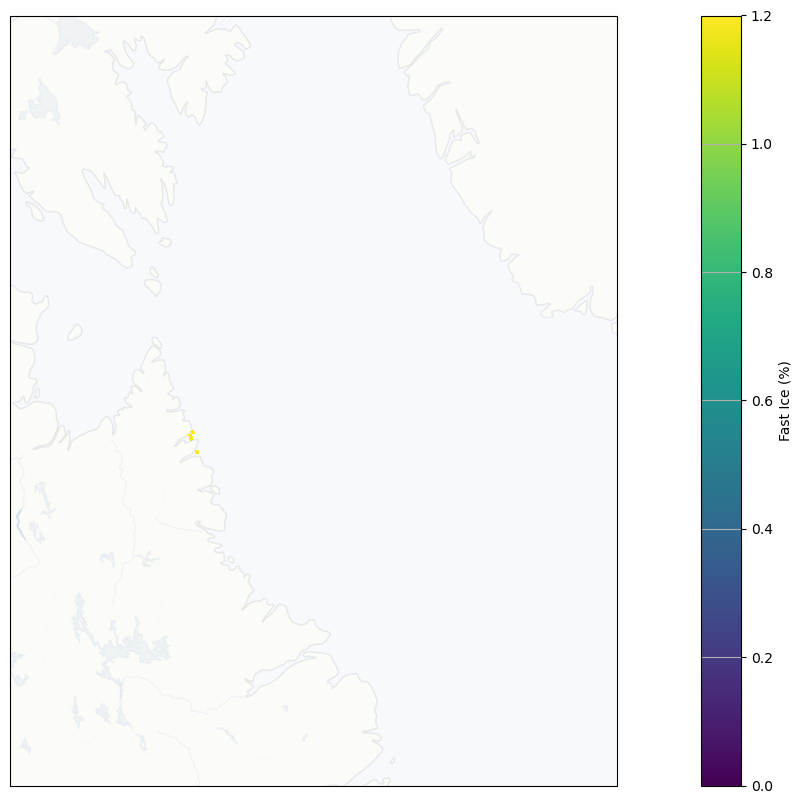

In [104]:
fig = plt.figure(figsize=(10,10))

#selected_data=[new_hi_hist_region]

titles=title=['HR-CESM \n0.1 cms$^{-1}$']
norm = plt.Normalize(0, 1.2)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
ax = plt.subplot(1,1, 1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
ax.coastlines(alpha=0.03, zorder=11)
ax.add_feature(cfeature.LAND, alpha=0.2)
ax.add_feature(cfeature.OCEAN, alpha=0.075)
ax.add_feature(cfeature.STATES, alpha=0.003)
ax.add_feature(cfeature.LAKES.with_scale('10m'),  alpha=0.1, zorder=2)
ax.add_feature(cfeature.RIVERS.with_scale('10m'),  alpha=0.1, zorder=2)
ax.set_extent([x0, x1, y0, y1])
ax.pcolormesh(model_fastIcee[0].TLON, model_fastIcee[0].TLAT, model_fastIcee[0],
                    norm=norm, transform=ccrs.PlateCarree(), zorder=1)


cbar_ax = fig.add_axes([0.9, 0.11, 0.04, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='Fast Ice (%)')
cbar.ax.tick_params(labelsize=10)
plt.grid()

plt.savefig('/storage2/tkyeimiah/Plots/Fig13.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [105]:
lon_min, lon_max =296, 299 #73W & 45W
lat_min, lat_max =58,60 
mask_u = ((hi_hist_region1.TLAT >= lat_min) & (hi_hist_region1.TLAT <= lat_max) &
        (hi_hist_region1.TLON >= lon_min) & (hi_hist_region1.TLON <= lon_max))

new_hi_hist_region=hi_hist_region1.sel(time=slice('1850','2005')).where(mask_u, drop=True)
new_hi_proj_region=hi_proj_region1.sel(time=slice('2006','2100')).where(mask_u, drop=True)
all_hist=xr.concat([new_hi_hist_region,new_hi_proj_region], dim='time')

###
#piomas_hi_all=piomas_data_region1.heff

In [106]:
lon_min, lon_max =296, 299 #73W & 45W
lat_min, lat_max =58,60 
mask_u = ((hi_hist_13lr_region1.TLAT >= lat_min) & (hi_hist_13lr_region1.TLAT <= lat_max) &
        (hi_hist_13lr_region1.TLON >= lon_min) & (hi_hist_13lr_region1.TLON <= lon_max))

new_hi_hist_region1=hi_hist_13lr_region1.sel(time=slice('1850','2005')).where(mask_u, drop=True)
new_hi_proj_region1=hi_proj_13lr_region1.sel(time=slice('2006','2100')).where(mask_u, drop=True)
all_hist_13lr=xr.concat([new_hi_hist_region1,new_hi_proj_region1], dim='time')

In [107]:
lon_min, lon_max =296, 299 #73W & 45W
lat_min, lat_max =58,60
mask_u = ((hi_lr_region.TLAT >= lat_min) & (hi_lr_region.TLAT <= lat_max) &
        (hi_lr_region.TLON >= lon_min) & (hi_lr_region.TLON <= lon_max))

all_lr_hist=hi_lr_region.where(mask_u, drop=True)

In [108]:
all_lr_hist

<xarray.DataArray 'hi' (time: 3012, nj: 6, ni: 4)>
array([[[       nan,        nan, 0.32310435,        nan],
        [       nan,        nan, 0.22042814, 0.2806654 ],
        [       nan, 0.33871338, 0.31483823,        nan],
        [0.3403333 , 0.30581644, 0.34891507,        nan],
        [0.282128  , 0.3615171 , 0.39270905,        nan],
        [       nan,        nan, 0.42891994,        nan]],

       [[       nan,        nan, 0.37205708,        nan],
        [       nan,        nan, 0.2607877 , 0.4221478 ],
        [       nan, 0.46471378, 0.4335366 ,        nan],
        [0.3797255 , 0.3552783 , 0.47649607,        nan],
        [0.3267944 , 0.47160244, 0.5868291 ,        nan],
        [       nan,        nan, 0.6693797 ,        nan]],

       [[       nan,        nan, 0.2880422 ,        nan],
        [       nan,        nan, 0.26347476, 0.29065767],
        [       nan, 0.45157304, 0.42471877,        nan],
        [0.42962122, 0.48548082, 0.5306074 ,        nan],
        [0.5603849 , 0.6517549 , 0.66923803,        nan],
        [       nan,        nan, 0.71006066,        nan]],
...
       [[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]],

       [[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]],

       [[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]]], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2100-12-01 00:00:00
    TLON     (nj, ni) float32 295.9 296.9 297.9 298.9 ... 297.6 298.6 299.5
    TLAT     (nj, ni) float32 58.18 58.09 58.0 57.92 ... 60.15 60.06 59.96 59.88
    ULON     (nj, ni) float32 296.5 297.5 298.4 299.4 ... 298.2 299.1 300.1
    ULAT     (nj, ni) float32 58.33 58.24 58.16 58.07 ... 60.3 60.2 60.11 60.03
Dimensions without coordinates: nj, ni
Attributes:
    long_name:     grid cell mean ice thickness
    units:         m
    cell_methods:  time: mean
    time_rep:      averaged

In [109]:
# Function to calculate the number of days above 0.3 meters in each month
def days_above_threshold(monthly_mean, threshold=0, days_in_month=30):
    days_above = 0
    for i in range(1, len(monthly_mean)):
        if monthly_mean[i-1] < threshold and monthly_mean[i] > threshold:
            days_above += (threshold - monthly_mean[i-1]) / (monthly_mean[i] - monthly_mean[i-1]) * days_in_month
        elif monthly_mean[i-1] > threshold and monthly_mean[i] < threshold:
            days_above += (monthly_mean[i-1] - threshold) / (monthly_mean[i-1] - monthly_mean[i]) * days_in_month
        elif monthly_mean[i-1] > threshold and monthly_mean[i] > threshold:
            days_above += days_in_month
    return days_above

# Calculate the total number of days above 0.3 meters for each year
ice_season_days = {}

for year in range(1850, 2101):
    yearly_data = all_hist.sel(time=str(year))
    monthly_mean = yearly_data.groupby('time.month').mean('time').mean(('nj', 'ni')).values
    days_above = days_above_threshold(monthly_mean)
    ice_season_days[year] = days_above

# Convert the result to a DataFrame and display
ice_season_days_df = pd.DataFrame(list(ice_season_days.items()), columns=['Year', 'Days'])

In [110]:
ice_season_days_df

Year  Days
0    1850   150
1    1851   180
2    1852   180
3    1853   180
4    1854   180
..    ...   ...
246  2096    30
247  2097     0
248  2098     0
249  2099    30
250  2100     0

[251 rows x 2 columns]

In [111]:
# Function to interpolate the day when thickness crosses 0.3 meters
def interpolate_day(thickness_before, thickness_after, threshold=0.3, days_in_month=30):
    if (thickness_before < threshold and thickness_after > threshold) or (thickness_before > threshold and thickness_after < threshold):
        f = interp1d([thickness_before, thickness_after], [0, days_in_month])
        return f(threshold)
    return None

# Calculate the total number of days above 0.3 meters for each year
def calculate_days_above_threshold(data, threshold=0.3):
    ice_season_days = {}

    for year in range(1850, 2101):
        yearly_data = data.sel(time=str(year))
        monthly_mean = yearly_data.groupby('time.month').mean('time').mean(('nj', 'ni')).values
        
        days_above = 0
        for i in range(len(monthly_mean) - 1):
            current_month_mean = monthly_mean[i]
            next_month_mean = monthly_mean[i + 1]
            
            if current_month_mean > threshold:
                days_above += 30  # Whole month is above threshold
            elif current_month_mean < threshold and next_month_mean > threshold:
                start_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if start_day is not None:
                    days_above += (30 - start_day)
            elif current_month_mean > threshold and next_month_mean < threshold:
                end_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if end_day is not None:
                    days_above += end_day
        
        # Handle December to January interpolation
        if monthly_mean[-1] > threshold:
            days_above += 30  # December is above threshold
        elif monthly_mean[-1] < threshold and monthly_mean[0] > threshold:
            start_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if start_day is not None:
                days_above += (30 - start_day)
        
        ice_season_days[year] = days_above

    return ice_season_days


ice_season_days = calculate_days_above_threshold(all_hist)

# Convert the result to a DataFrame and display
ice_season_days_dff = pd.DataFrame(list(ice_season_days.items()), columns=['Year', 'Days'])

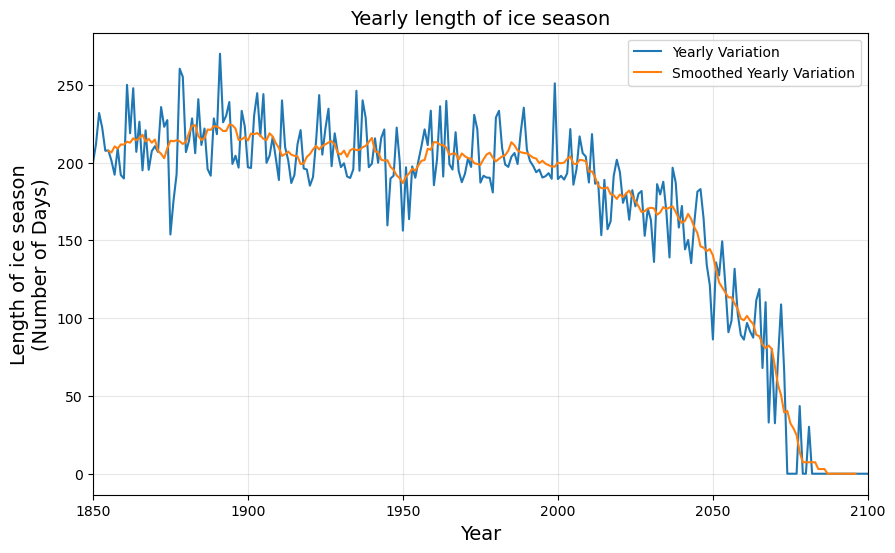

In [112]:
fig, ax=plt.subplots(figsize=(10,6))

# Calculate the mean across all years
#overall_mean = yearly_mean.mean('year')
# Create an array with the same size as the number of years with the overall mean value
#mean_line = np.full_like(yearly_mean, overall_mean)
# Plot the yearly variations and the mean line
ax.plot(ice_season_days_dff['Year'], ice_season_days_dff['Days'], label='Yearly Variation')
ax.plot(ice_season_days_dff['Year'], ice_season_days_dff['Days'].rolling(window=10, center=True).mean(), label='Smoothed Yearly Variation')

ax.set_title('Yearly length of ice season',  fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Length of ice season\n(Number of Days)', fontsize=14)
plt.grid(alpha=0.3)
plt.xlim(1850,2100)
plt.legend()
plt.savefig('/storage2/tkyeimiah/Plots/Iceseason_Length.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [113]:
def interpolate_day(thickness_before, thickness_after, threshold=0.3, days_in_month=30):
    if (thickness_before < threshold and thickness_after > threshold) or (thickness_before > threshold and thickness_after < threshold):
        f = interp1d([thickness_before, thickness_after], [0, days_in_month])
        return f(threshold)
    return None

def calculate_days_above_threshold(data, threshold=0.3):
    ice_season_days = {}

    for year in range(1850, 2101):
        yearly_data = data.sel(time=str(year))
        monthly_mean = yearly_data.groupby('time.month').mean('time').mean(('nj', 'ni')).values
        
        
        days_above = 0
        for i in range(len(monthly_mean) - 1):
            current_month_mean = monthly_mean[i]
            next_month_mean = monthly_mean[i + 1]
            
            if current_month_mean > threshold and next_month_mean > threshold:
                days_above += 30  # Whole month is above threshold
            elif current_month_mean < threshold and next_month_mean > threshold:
                start_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if start_day is not None:
                    days_above += (30 - start_day)
            elif current_month_mean > threshold and next_month_mean < threshold:
                end_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if end_day is not None:
                    days_above += end_day
        
        # Handle December to January interpolation
        if monthly_mean[-1] > threshold and monthly_mean[0] > threshold:
            days_above += 30  # Both December and January are above threshold
        elif monthly_mean[-1] < threshold and monthly_mean[0] > threshold:
            start_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if start_day is not None:
                days_above += (30 - start_day)
        elif monthly_mean[-1] > threshold and monthly_mean[0] < threshold:
            end_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if end_day is not None:
                days_above += end_day
        
        ice_season_days[year] = days_above

    return ice_season_days

# Assuming `all_hist` is your dataset
ice_season_days = calculate_days_above_threshold(all_hist)

# Convert the result to a DataFrame and display
ice_season_days_df = pd.DataFrame(list(ice_season_days.items()), columns=['Year', 'Days'])

In [114]:
def interpolate_day(thickness_before, thickness_after, threshold=0.3, days_in_month=30):
    if (thickness_before < threshold and thickness_after > threshold) or (thickness_before > threshold and thickness_after < threshold):
        f = interp1d([thickness_before, thickness_after], [0, days_in_month])
        return f(threshold)
    return None

def calculate_days_above_threshold(data, threshold=0.3):
    ice_season_days = {}

    for year in range(1850, 2101):
        yearly_data = data.sel(time=str(year))
        monthly_mean = yearly_data.groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0).values

        days_above = 0
        for i in range(len(monthly_mean) - 1):
            current_month_mean = monthly_mean[i]
            next_month_mean = monthly_mean[i + 1]

            if current_month_mean > threshold and next_month_mean > threshold:
                days_above += 30  # Whole month is above threshold
            elif current_month_mean < threshold and next_month_mean > threshold:
                start_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if start_day is not None:
                    days_above += (30 - start_day)
            elif current_month_mean > threshold and next_month_mean < threshold:
                end_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if end_day is not None:
                    days_above += end_day

        # Handle December to January interpolation
        if monthly_mean[-1] > threshold and monthly_mean[0] > threshold:
            days_above += 30  # Both December and January are above threshold
        elif monthly_mean[-1] < threshold and monthly_mean[0] > threshold:
            start_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if start_day is not None:
                days_above += (30 - start_day)
        elif monthly_mean[-1] > threshold and monthly_mean[0] < threshold:
            end_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if end_day is not None:
                days_above += end_day

        ice_season_days[year] = days_above

    return ice_season_days

# Assuming `all_hist` is your dataset
ice_season_days = calculate_days_above_threshold(all_hist)

# Convert the result to a DataFrame and display
ice_season_days_df = pd.DataFrame(list(ice_season_days.items()), columns=['Year', 'Days'])

In [115]:
yearly_data = all_hist.sel(time=str(1850))
monthly_mean = yearly_data.groupby('time.month').mean('time').mean(('nj', 'ni')).values

In [116]:
def interpolate_day(thickness_before, thickness_after, threshold=0.3, days_in_month=30):
    if (thickness_before < threshold and thickness_after > threshold) or (thickness_before > threshold and thickness_after < threshold):
        f = interp1d([thickness_before, thickness_after], [0, days_in_month])
        return f(threshold)
    return None

def calculate_days_above_threshold(data, threshold=0.3):
    ice_season_days = {}

    for year in range(1850, 2101):
        yearly_data = data.sel(time=str(year))
        monthly_mean = yearly_data.groupby('time.month').mean('time').mean(('nj', 'ni')).values
        
        
        days_above = 0
        for i in range(len(monthly_mean) - 1):
            current_month_mean = monthly_mean[i]
            next_month_mean = monthly_mean[i + 1]
            
            if current_month_mean > threshold and next_month_mean > threshold:
                days_above += 30  # Whole month is above threshold
            elif current_month_mean < threshold and next_month_mean > threshold:
                start_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if start_day is not None:
                    days_above += (30 - start_day)
            elif current_month_mean > threshold and next_month_mean < threshold:
                end_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if end_day is not None:
                    days_above += end_day
        
        # Handle December to January interpolation
        if monthly_mean[-1] > threshold and monthly_mean[0] > threshold:
            days_above += 30  # Both December and January are above threshold
        elif monthly_mean[-1] < threshold and monthly_mean[0] > threshold:
            start_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if start_day is not None:
                days_above += (30 - start_day)
        elif monthly_mean[-1] > threshold and monthly_mean[0] < threshold:
            end_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if end_day is not None:
                days_above += end_day
        
        ice_season_days[year] = days_above

    return ice_season_days

# Assuming `all_hist` is your dataset
ice_season_daysSlr = calculate_days_above_threshold(all_hist_13lr)

# Convert the result to a DataFrame and display
ice_season_days_df13lr = pd.DataFrame(list(ice_season_daysSlr.items()), columns=['Year', 'Days'])

In [117]:
def interpolate_day(thickness_before, thickness_after, threshold=0.3, days_in_month=30):
    if (thickness_before < threshold and thickness_after > threshold) or (thickness_before > threshold and thickness_after < threshold):
        f = interp1d([thickness_before, thickness_after], [0, days_in_month])
        return f(threshold)
    return None

def calculate_days_above_threshold(data, threshold=0.3):
    ice_season_days = {}

    for year in range(1850, 2101):
        yearly_data = data.sel(time=str(year))
        monthly_mean = yearly_data.groupby('time.month').mean('time').mean(('nj', 'ni')).values
        
        
        days_above = 0
        for i in range(len(monthly_mean) - 1):
            current_month_mean = monthly_mean[i]
            next_month_mean = monthly_mean[i + 1]
            
            if current_month_mean > threshold and next_month_mean > threshold:
                days_above += 30  # Whole month is above threshold
            elif current_month_mean < threshold and next_month_mean > threshold:
                start_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if start_day is not None:
                    days_above += (30 - start_day)
            elif current_month_mean > threshold and next_month_mean < threshold:
                end_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if end_day is not None:
                    days_above += end_day
        
        # Handle December to January interpolation
        if monthly_mean[-1] > threshold and monthly_mean[0] > threshold:
            days_above += 30  # Both December and January are above threshold
        elif monthly_mean[-1] < threshold and monthly_mean[0] > threshold:
            start_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if start_day is not None:
                days_above += (30 - start_day)
        elif monthly_mean[-1] > threshold and monthly_mean[0] < threshold:
            end_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if end_day is not None:
                days_above += end_day
        
        ice_season_days[year] = days_above

    return ice_season_days

# Assuming `all_hist` is your dataset
ice_season_daysS = calculate_days_above_threshold(all_lr_hist)

# Convert the result to a DataFrame and display
ice_season_days_dflr = pd.DataFrame(list(ice_season_daysS.items()), columns=['Year', 'Days'])

In [118]:
ice_season_days_dflr

Year        Days
0    1850  150.000000
1    1851  139.823333
2    1852  153.150177
3    1853  154.214804
4    1854  141.298158
..    ...         ...
246  2096    0.000000
247  2097    0.000000
248  2098    0.000000
249  2099    0.000000
250  2100    0.000000

[251 rows x 2 columns]

In [119]:
def calculate_days_above_threshold1(data, threshold=0.3):
    ice_season_days = {}

    for year in range(1990, 2021):
        yearly_data = data.sel(time=str(year))
        monthly_mean = yearly_data.groupby('time.month').mean('time').mean(('rlat', 'rlon')).values
        
        
        days_above = 0
        for i in range(len(monthly_mean) - 1):
            current_month_mean = monthly_mean[i]
            next_month_mean = monthly_mean[i + 1]
            
            if current_month_mean > threshold and next_month_mean > threshold:
                days_above += 30  # Whole month is above threshold
            elif current_month_mean < threshold and next_month_mean > threshold:
                start_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if start_day is not None:
                    days_above += (30 - start_day)
            elif current_month_mean > threshold and next_month_mean < threshold:
                end_day = interpolate_day(current_month_mean, next_month_mean, threshold)
                if end_day is not None:
                    days_above += end_day
        
        # Handle December to January interpolation
        if monthly_mean[-1] > threshold and monthly_mean[0] > threshold:
            days_above += 30  # Both December and January are above threshold
        elif monthly_mean[-1] < threshold and monthly_mean[0] > threshold:
            start_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if start_day is not None:
                days_above += (30 - start_day)
        elif monthly_mean[-1] > threshold and monthly_mean[0] < threshold:
            end_day = interpolate_day(monthly_mean[-1], monthly_mean[0], threshold)
            if end_day is not None:
                days_above += end_day
        
        ice_season_days[year] = days_above

    return ice_season_days

# Assuming `all_hist` is your dataset
ice_season_days1 = calculate_days_above_threshold1(obs_thick_region2*0.01)

# Convert the result to a DataFrame and display
ice_season_days_df1 = pd.DataFrame(list(ice_season_days1.items()), columns=['Year', 'Days'])

In [120]:
ice_season_days_df

Year        Days
0    1850  184.936880
1    1851  186.173851
2    1852  212.666318
3    1853  206.810776
4    1854  190.914316
..    ...         ...
246  2096    0.000000
247  2097    0.000000
248  2098    0.000000
249  2099    0.000000
250  2100    0.000000

[251 rows x 2 columns]

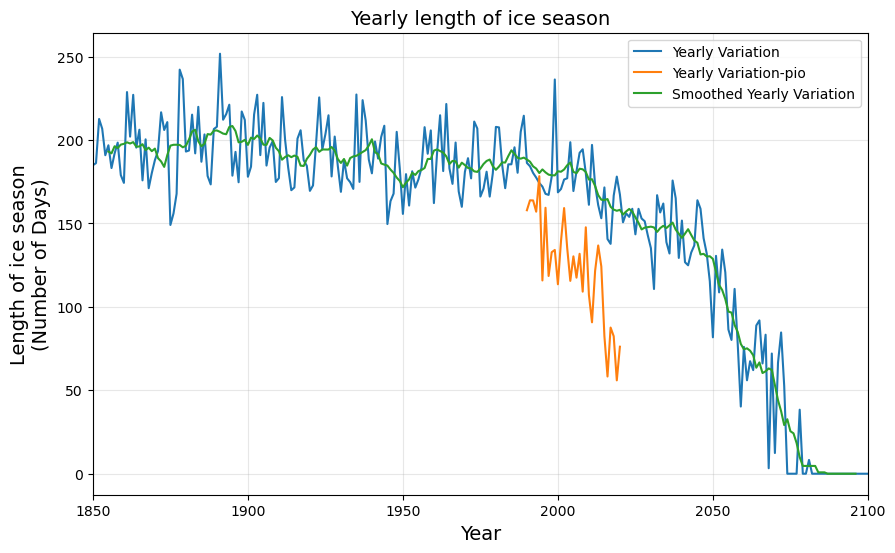

In [121]:
fig, ax=plt.subplots(figsize=(10,6))

# Calculate the mean across all years
#overall_mean = yearly_mean.mean('year')
# Create an array with the same size as the number of years with the overall mean value
#mean_line = np.full_like(yearly_mean, overall_mean)
# Plot the yearly variations and the mean line
ax.plot(ice_season_days_df['Year'], ice_season_days_df['Days'], label='Yearly Variation')
ax.plot(ice_season_days_df1['Year'],ice_season_days_df1['Days'], label='Yearly Variation-pio')
ax.plot(ice_season_days_df['Year'], ice_season_days_df['Days'].rolling(window=10, center=True).mean(), label='Smoothed Yearly Variation')

ax.set_title('Yearly length of ice season',  fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Length of ice season\n(Number of Days)', fontsize=14)
plt.grid(alpha=0.3)
plt.xlim(1850,2100)
plt.legend()
plt.savefig('/storage2/tkyeimiah/Plots/Iceseason_Length.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [122]:
_1850 = all_hist.sel(time=str(1850))
_1900 = all_hist.sel(time=str(1851))
_1950 = all_hist.sel(time=str(1950))
_2000 = all_hist.sel(time=str(2000))
_2050 = all_hist.sel(time=str(2050))
_2100 = all_hist.sel(time=str(2100))

In [123]:
monthly_mean_1850 = _1850.groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
monthly_mean_1900 = _1900.groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
monthly_mean_1950 = _1950.groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
monthly_mean_2000 = _2000.groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
monthly_mean_2050 = _2050.groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
monthly_mean_2100 = _2100.groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)

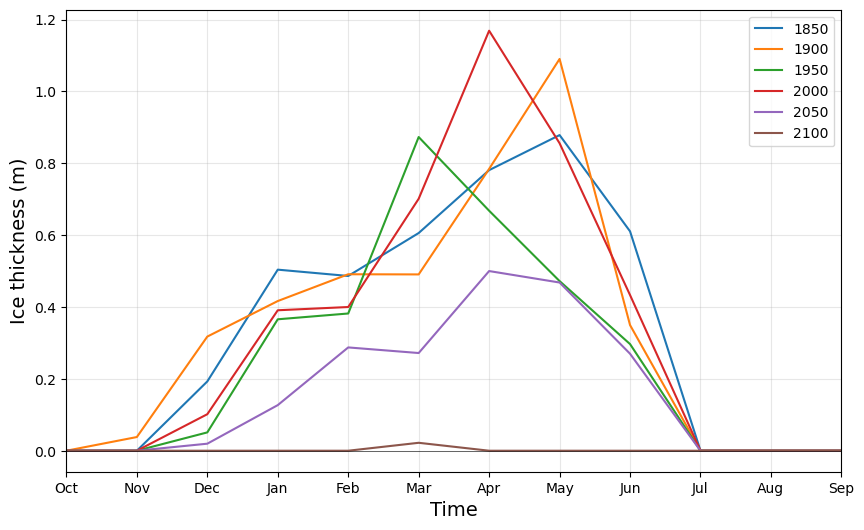

In [124]:
fig, ax=plt.subplots(figsize=(10,6))
month_dt = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep']
ax.plot(month_dt, np.append(monthly_mean_1850[9:],monthly_mean_1850[:9]) , label='1850')
ax.plot(month_dt, np.append(monthly_mean_1900[9:],monthly_mean_1900[:9]) , label='1900')
ax.plot(month_dt, np.append(monthly_mean_1950[9:],monthly_mean_1950[:9]) , label='1950')
ax.plot(month_dt, np.append(monthly_mean_2000[9:],monthly_mean_2000[:9]) , label='2000')
ax.plot(month_dt, np.append(monthly_mean_2050[9:],monthly_mean_2050[:9]) , label='2050')
ax.plot(month_dt, np.append(monthly_mean_2100[9:],monthly_mean_2100[:9]) , label='2100')
plt.axhline(y=0, color='black', linewidth=0.4)
#ax.set_title('Yearly length of ice season',  fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Ice thickness (m)', fontsize=14)
plt.grid(alpha=0.3)
plt.xlim(0,11)
#plt.xlim(1850,2100)
plt.legend()
plt.savefig('/storage2/tkyeimiah/Plots/timeSeries.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [125]:
obs_SIE_march

<xarray.DataArray (time: 31)>
array([1.0321423 , 0.91988359, 0.88082156, 0.99801854, 0.91150692,
       0.87890708, 0.79725311, 0.80831114, 0.78588518, 0.77936666,
       0.84076833, 0.80432339, 0.76216806, 0.7400009 , 0.66682084,
       0.69894935, 0.59213104, 0.74037295, 0.92868838, 0.84891249,
       0.66619557, 0.71401774, 0.9210548 , 0.69922861, 0.86165184,
       0.85631848, 0.82483082, 0.77322292, 0.79302201, 0.71980168,
       0.96913573])
Coordinates:
  * time     (time) datetime64[ns] 1990-03-31 1991-03-31 ... 2020-03-31

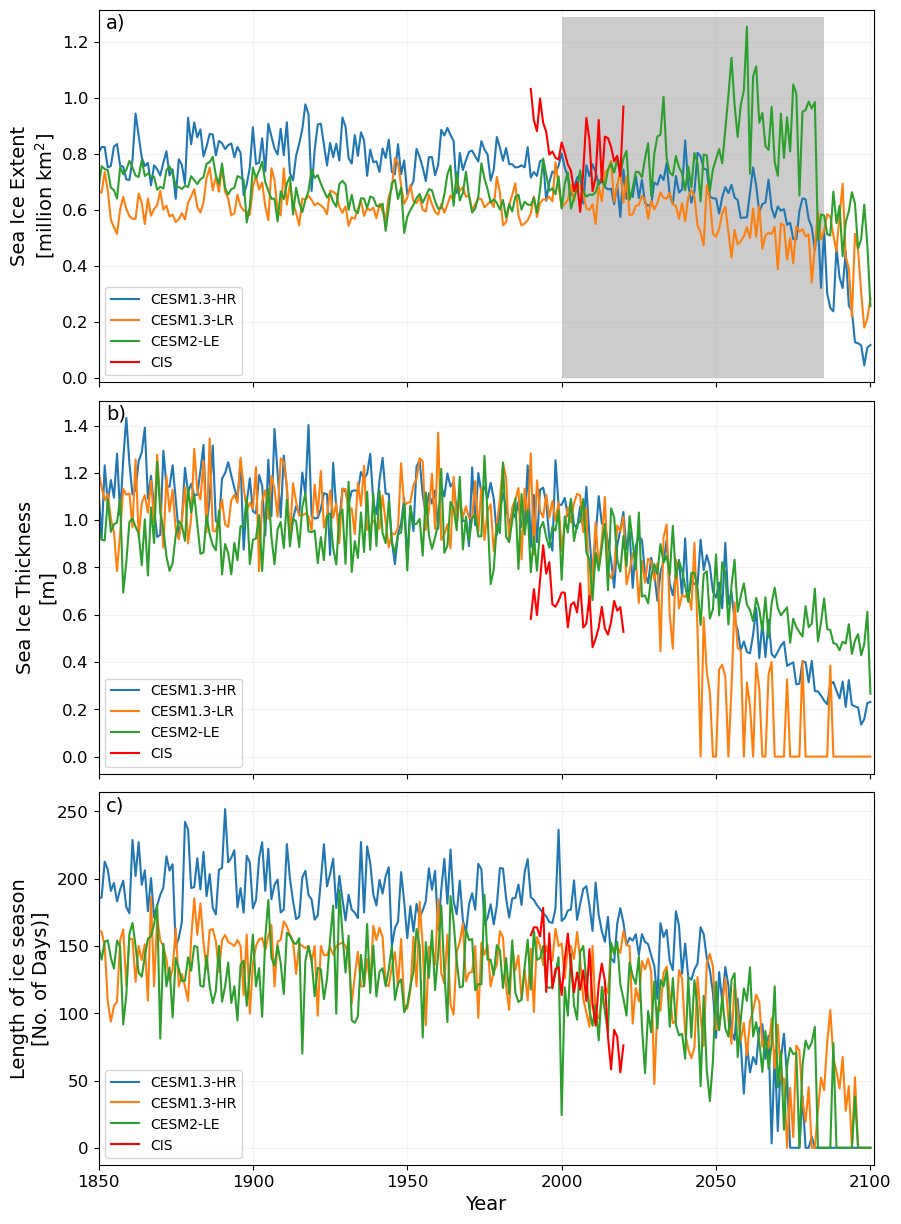

In [126]:
# SIE  : CESM1.3-HR
march_aice_hist = aice_hist_region.sel(time=slice('1850','2005'))[2::12].sum(('nj', 'ni'))
march_aice_proj = aice_proj_region.sel(time=slice('2006','2100'))[2::12].sum(('nj', 'ni'))
march_aice=xr.concat([march_aice_hist,march_aice_proj], dim='time')

# SIE  : CESM1.3-LR
march_aice_hist_13lr = aice_hist_13lr_region.sel(time=slice('1850','2005'))[2::12].sum(('nj', 'ni'))
march_aice_proj_13lr = aice_proj_13lr_region.sel(time=slice('2006','2100'))[2::12].sum(('nj', 'ni'))
march_aice_13lr=xr.concat([march_aice_hist_13lr,march_aice_proj_13lr], dim='time')

# SIE : CIS
obs_SIE=obs_CT_region.sel(time=slice('1990','2020'))
obs_SIE_march=obs_SIE[2::12].sum(['rlat','rlon'])

# SIT : CESM1.3-HR
march_hi_hist = hi_hist_region1.sel(time=slice('1850','2005'))[4::12].mean(('nj', 'ni'))
march_hi_proj = hi_proj_region1.sel(time=slice('2006','2100'))[4::12].mean(('nj', 'ni'))
march_hi=xr.concat([march_hi_hist,march_hi_proj], dim='time')

# SIT : CESM1.3-LR
march_hi_hist_13lr = hi_hist_13lr_region1.sel(time=slice('1850','2005'))[4::12].mean(('nj', 'ni'))
march_hi_proj_13lr = hi_proj_13lr_region1.sel(time=slice('2006','2100'))[4::12].mean(('nj', 'ni')).fillna(0)
march_hi_13lr=xr.concat([march_hi_hist_13lr,march_hi_proj_13lr], dim='time')


# SIT : CIS
obs_SIT=obs_thick_region1.sel(time=slice('1990','2020'))
march_obs_hi = obs_SIT[4::12].mean(['rlat','rlon'])

# SIT  : LR-CESM
march_hi_LR= hi_lr_region.sel(time=slice('1850','2100'))[4::12].mean(('nj', 'ni'))


fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
years =np.arange(1850,2101,1)

# First plot              
ax[0].plot(years, march_aice, label='CESM1.3-HR')
ax[0].plot(years, march_aice_13lr, label='CESM1.3-LR')
ax[0].plot(years, march_aice_LR, label='CESM2-LE')
ax[0].plot(np.arange(1990,2021), obs_SIE_march, color='red', label='CIS')
ax[0].set_ylabel('Sea Ice Extent\n[million km$^2$]', fontsize=14)
ax[0].grid(alpha=0.15)     
ax[0].legend(loc='lower left')
ax[0].set_xlim(1850, 2101)

# Second plot         
ax[1].plot(years, march_hi.fillna((0.08338354+0.1498341)/2), label='CESM1.3-HR')
ax[1].plot(years, march_hi_13lr, label='CESM1.3-LR')
ax[1].plot(years, march_hi_LR, label='CESM2-LE')
ax[1].plot(np.arange(1990,2021), march_obs_hi*0.01, color='red', label='CIS')
ax[1].set_ylabel('Sea Ice Thickness\n[m]', fontsize=14)
ax[1].grid(alpha=0.15)
ax[1].legend(loc='lower left') 

# Third plot         
ax[2].plot(years, ice_season_days_df['Days'], label='CESM1.3-HR')
ax[2].plot(years, ice_season_days_df13lr['Days'], label='CESM1.3-HR')
ax[2].plot(years, ice_season_days_dflr['Days'], label='CESM2-LE')
ax[2].plot(np.arange(1990,2021), ice_season_days_df1['Days'], color='red', label='CIS')
ax[2].set_ylabel('Length of ice season\n[No. of Days)]', fontsize=14)
ax[2].grid(alpha=0.15)
ax[2].legend(loc='lower left') 
ax[2].set_xlabel('Year', fontsize=14)

rect=ax[0].add_patch(Rectangle((2000, 0.0), 85, 1.29, edgecolor=None,facecolor='grey',lw=3,alpha=0.4))
#rect1=ax[0].add_patch(Rectangle((2000, 0.43), 85, 0.86, edgecolor='black',facecolor=None,lw=3,))
#rect1.set_zorder(10)

# Increase the size of the tick labels
for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)

ax[0].text(0.01, 0.95, 'a)',transform=ax[0].transAxes,  fontsize=14)
ax[1].text(0.01, 0.95, 'b)',transform=ax[1].transAxes,  fontsize=14)
ax[2].text(0.01, 0.95, 'c)',transform=ax[2].transAxes,  fontsize=14)
plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/Fig6.jpg', dpi=500, bbox_inches='tight')
plt.show()

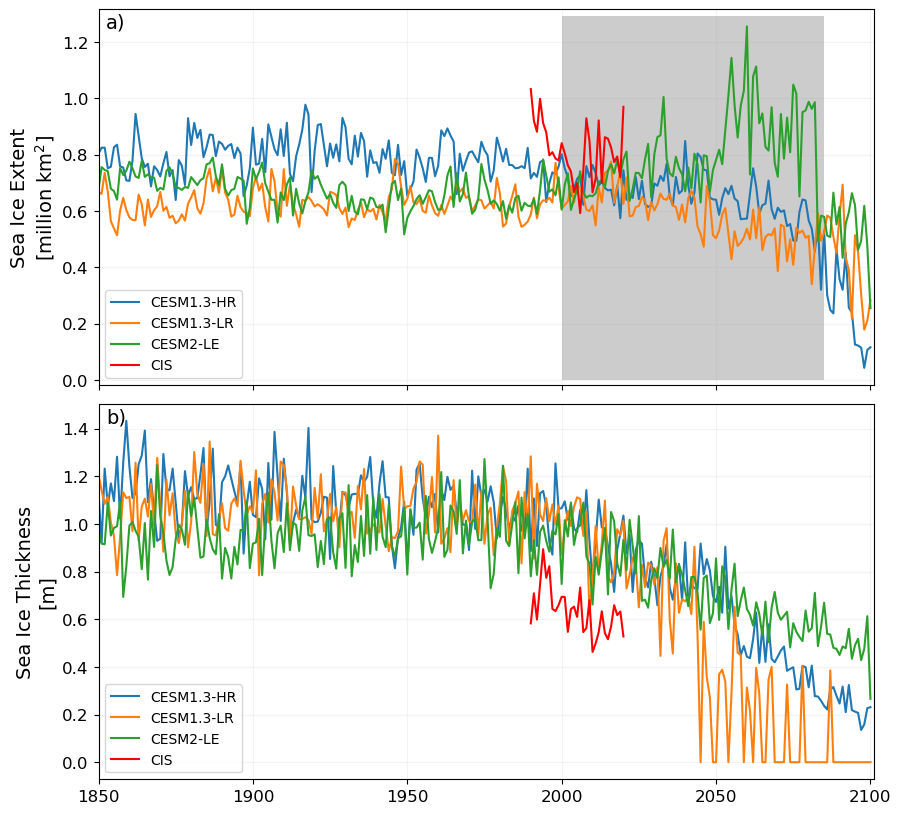

In [127]:
# SIE  : CESM1.3-HR
march_aice_hist = aice_hist_region.sel(time=slice('1850','2005'))[2::12].sum(('nj', 'ni'))
march_aice_proj = aice_proj_region.sel(time=slice('2006','2100'))[2::12].sum(('nj', 'ni'))
march_aice=xr.concat([march_aice_hist,march_aice_proj], dim='time')

# SIE  : CESM1.3-LR
march_aice_hist_13lr = aice_hist_13lr_region.sel(time=slice('1850','2005'))[2::12].sum(('nj', 'ni'))
march_aice_proj_13lr = aice_proj_13lr_region.sel(time=slice('2006','2100'))[2::12].sum(('nj', 'ni'))
march_aice_13lr=xr.concat([march_aice_hist_13lr,march_aice_proj_13lr], dim='time')

# SIE : CIS
obs_SIE=obs_CT_region.sel(time=slice('1990','2020'))
obs_SIE_march=obs_SIE[2::12].sum(['rlat','rlon'])

# SIT : CESM1.3-HR
march_hi_hist = hi_hist_region1.sel(time=slice('1850','2005'))[4::12].mean(('nj', 'ni'))
march_hi_proj = hi_proj_region1.sel(time=slice('2006','2100'))[4::12].mean(('nj', 'ni'))
march_hi=xr.concat([march_hi_hist,march_hi_proj], dim='time')

# SIT : CESM1.3-LR
march_hi_hist_13lr = hi_hist_13lr_region1.sel(time=slice('1850','2005'))[4::12].mean(('nj', 'ni'))
march_hi_proj_13lr = hi_proj_13lr_region1.sel(time=slice('2006','2100'))[4::12].mean(('nj', 'ni')).fillna(0)
march_hi_13lr=xr.concat([march_hi_hist_13lr,march_hi_proj_13lr], dim='time')


# SIT : CIS
obs_SIT=obs_thick_region1.sel(time=slice('1990','2020'))
march_obs_hi = obs_SIT[4::12].mean(['rlat','rlon'])

# SIT  : LR-CESM
march_hi_LR= hi_lr_region.sel(time=slice('1850','2100'))[4::12].mean(('nj', 'ni'))


fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
years =np.arange(1850,2101,1)

# First plot              
ax[0].plot(years, march_aice, label='CESM1.3-HR')
ax[0].plot(years, march_aice_13lr, label='CESM1.3-LR')
ax[0].plot(years, march_aice_LR, label='CESM2-LE')
ax[0].plot(np.arange(1990,2021), obs_SIE_march, color='red', label='CIS')
ax[0].set_ylabel('Sea Ice Extent\n[million km$^2$]', fontsize=14)
ax[0].grid(alpha=0.15)     
ax[0].legend(loc='lower left')
ax[0].set_xlim(1850, 2101)

# Second plot         
ax[1].plot(years, march_hi.fillna((0.08338354+0.1498341)/2), label='CESM1.3-HR')
ax[1].plot(years, march_hi_13lr, label='CESM1.3-LR')
ax[1].plot(years, march_hi_LR, label='CESM2-LE')
ax[1].plot(np.arange(1990,2021), march_obs_hi*0.01, color='red', label='CIS')
ax[1].set_ylabel('Sea Ice Thickness\n[m]', fontsize=14)
ax[1].grid(alpha=0.15)
ax[1].legend(loc='lower left') 

rect=ax[0].add_patch(Rectangle((2000, 0.0), 85, 1.29, edgecolor=None,facecolor='grey',lw=3,alpha=0.4))
#rect1=ax[0].add_patch(Rectangle((2000, 0.43), 85, 0.86, edgecolor='black',facecolor=None,lw=3,))
#rect1.set_zorder(10)

# Increase the size of the tick labels
for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)

ax[0].text(0.01, 0.95, 'a)',transform=ax[0].transAxes,  fontsize=14)
ax[1].text(0.01, 0.95, 'b)',transform=ax[1].transAxes,  fontsize=14)
plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/new_Fig4.jpg', dpi=500, bbox_inches='tight')
plt.show()

In [128]:
obs_CT_sel_1990=obs_CT_sel.sel(time='1990')
obs_CT_sel_2006=obs_CT_sel.sel(time='2006')

model_CT_sel_1990=model_CT_sel.sel(time='1990')
model_CT_sel_2006=model_CT_sel.sel(time='2006')

obs_CT_sel_1990a=obs_total_region.sel(time='1990')
obs_CT_sel_2006a=obs_total_region.sel(time='2006')

In [129]:
cd

/aos/home/tkyeimiah


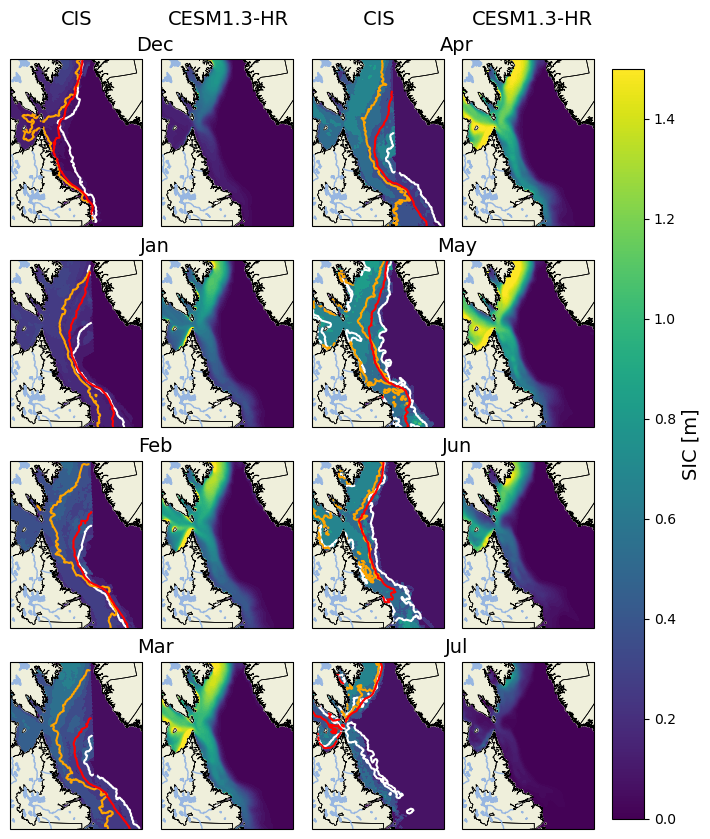

In [130]:
fig = plt.figure(figsize=(8,10))
thick_data=[obs_thick_months[-1],obs_thick_months[3],obs_thick_months[0],obs_thick_months[4],
          obs_thick_months[1],obs_thick_months[5],obs_thick_months[2],obs_thick_months[6]]

model_data=[hi_months[-1], hi_months[3], hi_months[0], hi_months[4], hi_months[1], hi_months[5],
            hi_months[2], hi_months[6]]

obs_data1=[obs_months[-1],obs_months[3], obs_months[0],obs_months[4], obs_months[1],obs_months[5],
          obs_months[2],obs_months[6]]

obs_1990=[obs_CT_sel_1990[-1],obs_CT_sel_1990[3], obs_CT_sel_1990[0],obs_CT_sel_1990[4], obs_CT_sel_1990[1],obs_CT_sel_1990[5],
          obs_CT_sel_1990[2],obs_CT_sel_1990[6]]

obs_2006=[obs_CT_sel_2006[-1],obs_CT_sel_2006[3], obs_CT_sel_2006[0],obs_CT_sel_2006[4], obs_CT_sel_2006[1],obs_CT_sel_2006[5],
          obs_CT_sel_2006[2],obs_CT_sel_2006[6]]

titles = ['Dec','Apr','Jan','May','Feb','Jun','Mar','Jul',]
#name=['a)','c)','e)','g)','i)','k)','m)','o)','q)']
#name1=['b)','d)','f)','h)','j)','l)','n)','p)','r)']

norm = plt.Normalize(vmin=0, vmax=1.5)
#norm2= plt.Normalize(vmin=0, vmax=1.7)
norm1= plt.Normalize(vmin=0, vmax=1.5)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i in range(16):
    index = i // 2 
    
    if i % 2 == 0:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        ax.coastlines()
        ax.set_title(titles[index], fontsize=14, x=1.1)
        ax.add_feature(cfeature.LAND, zorder=2)
        ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
        ax.set_extent([x0, x1, y0, y1])
        ax.contourf(thick_data[index].lon, thick_data[index].lat, thick_data[index].fillna(0)*0.01,  norm=norm1,
                    transform=ccrs.PlateCarree())
       
        ax.contour(obs_1990[index].lon, obs_1990[index].lat, obs_1990[index]*100, levels=[15], norm=norm,  colors='white',
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        
        ax.contour(obs_2006[index].lon, obs_2006[index].lat, obs_2006[index]*100, levels=[15], norm=norm,  colors='orange',
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        
        ax.contour(obs_data1[index].lon, obs_data1[index].lat, obs_data1[index]*100, levels=[15], norm=norm,  colors='red',
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        
        
    else:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        if index < len(model_data):
            #ax.set_title(titles[index], fontsize=14)
            ax.add_feature(cfeature.LAND, zorder=2)
            ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
            ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
            ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
            ax.set_extent([x0, x1, y0, y1])
            ax.contourf(model_data[index].TLON, model_data[index].TLAT, model_data[index],levels=100, norm=norm,
                        transform=ccrs.PlateCarree(), zorder=1)

cbar_ax = fig.add_axes([0.9, 0.12, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [m]', fontsize=14)

name=['CIS', 'CESM1.3-HR', ' CIS', 'CESM1.3-HR']
x=[0.23, 0.42, 0.605, 0.8]
y=[0.91,0.91,0.91,0.91]
for i in range (4):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='horizontal',
             rotation_mode='anchor',fontsize=14)


plt.subplots_adjust(wspace=-0.1)
plt.savefig('/storage2/tkyeimiah/Plots/Fig4-.jpg',dpi=500, bbox_inches='tight')
plt.show()

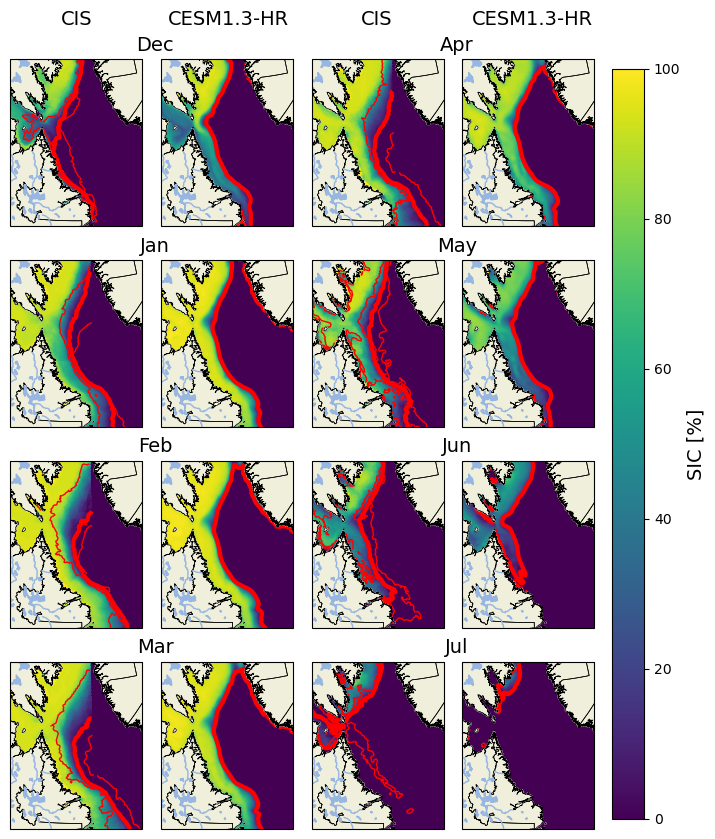

In [131]:
fig = plt.figure(figsize=(8,10))

####1
obs_data=[obs_months[-1],obs_months[3], obs_months[0],obs_months[4], obs_months[1],obs_months[5],
          obs_months[2],obs_months[6]]

obs_1990=[obs_CT_sel_1990[-1],obs_CT_sel_1990[3], obs_CT_sel_1990[0],obs_CT_sel_1990[4], obs_CT_sel_1990[1],obs_CT_sel_1990[5],
          obs_CT_sel_1990[2],obs_CT_sel_1990[6]]

obs_2006=[obs_CT_sel_2006[-1],obs_CT_sel_2006[3], obs_CT_sel_2006[0],obs_CT_sel_2006[4], obs_CT_sel_2006[1],obs_CT_sel_2006[5],
          obs_CT_sel_2006[2],obs_CT_sel_2006[6]]

####2
model_data=[model_months[-1],model_months[3], model_months[0],model_months[4], model_months[1],model_months[5],
            model_months[2],model_months[6]]

model_1990=[model_CT_sel_1990[-1],model_CT_sel_1990[3], model_CT_sel_1990[0],model_CT_sel_1990[4], model_CT_sel_1990[1],model_CT_sel_1990[5],
          model_CT_sel_1990[2],model_CT_sel_1990[6]]

model_2006=[model_CT_sel_2006[-1],model_CT_sel_2006[3], model_CT_sel_2006[0],model_CT_sel_2006[4], model_CT_sel_2006[1],model_CT_sel_2006[5],
          model_CT_sel_2006[2],model_CT_sel_2006[6]]

titles = ['Dec','Apr','Jan','May','Feb','Jun','Mar','Jul',]
norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i in range(16):
    index = i // 2 
    
    if i % 2 == 0:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        ax.set_title(titles[index], fontsize=14, x=1.1)
        ax.add_feature(cfeature.LAND, zorder=2)
        ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
        ax.set_extent([x0, x1, y0, y1])
        ax.contourf(obs_data[index].lon, obs_data[index].lat, obs_data[index].fillna(0)*100, vmin=15,levels=100,
                    transform=ccrs.PlateCarree(), zorder=1)
        
        ax.contour(obs_1990[index].lon, obs_1990[index].lat, obs_1990[index]*100, levels=[15], norm=norm,  colors='red',linewidths=1,
                   transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(obs_2006[index].lon, obs_2006[index].lat, obs_2006[index]*100, levels=[15], norm=norm,  colors='red',linewidths=1,
                   transform=ccrs.PlateCarree(), zorder=1)
        
        ax.contour(obs_data[index].lon, obs_data[index].lat, obs_data[index]*100, levels=[15], norm=norm,  colors='red',
                   linewidths=3, transform=ccrs.PlateCarree(), zorder=1)
        
       
        
    else:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        if index < len(model_data):
            #ax.set_title(titles[index], fontsize=14)
            ax.add_feature(cfeature.LAND, zorder=2)
            ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
            ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
            ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
            ax.set_extent([x0, x1, y0, y1])
            ax.contourf(model_data[index].TLON, model_data[index].TLAT, model_data[index], levels=100, 
                        vmin=15, transform=ccrs.PlateCarree(), zorder=1)
            
            #ax.contour(model_1990[index].TLON, model_1990[index].TLAT, model_1990[index], levels=[15], norm=norm,  colors='white',linewidths=1.5,
                       #transform=ccrs.PlateCarree(), zorder=1)
            #ax.contour(model_2006[index].TLON, model_2006[index].TLAT, model_2006[index], levels=[15], norm=norm,  colors='white',linewidths=1.5,
                       #transform=ccrs.PlateCarree(), zorder=1)
            
            ax.contour(model_data[index].TLON, model_data[index].TLAT, model_data[index], levels=[15], norm=norm, colors='red',
                       linewidths=3,transform=ccrs.PlateCarree(), zorder=1)
            
cbar_ax = fig.add_axes([0.9, 0.12, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=14)

name=['CIS', 'CESM1.3-HR','CIS', 'CESM1.3-HR']
x=[0.23, 0.42, 0.605, 0.8]
y=[0.91,0.91,0.91,0.91]
for i in range (4):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='horizontal',
             rotation_mode='anchor',fontsize=14)


plt.subplots_adjust(wspace=-0.1)
plt.savefig('/storage2/tkyeimiah/Plots/Fig3.jpg',dpi=500, bbox_inches='tight')
plt.show()


In [132]:
fig = plt.figure(figsize=(8,10))


####1
thick_data=[obs_thick_months[-1],obs_thick_months[3],obs_thick_months[0],obs_thick_months[4],
          obs_thick_months[1],obs_thick_months[5],obs_thick_months[2],obs_thick_months[6]]

obs_data=[obs_months[-1],obs_months[3], obs_months[0],obs_months[4], obs_months[1],obs_months[5],
          obs_months[2],obs_months[6]]

obs_1990=[obs_CT_sel_1990[-1],obs_CT_sel_1990[3], obs_CT_sel_1990[0],obs_CT_sel_1990[4], obs_CT_sel_1990[1],obs_CT_sel_1990[5],
          obs_CT_sel_1990[2],obs_CT_sel_1990[6]]

obs_2006=[obs_CT_sel_2006[-1],obs_CT_sel_2006[3], obs_CT_sel_2006[0],obs_CT_sel_2006[4], obs_CT_sel_2006[1],obs_CT_sel_2006[5],
          obs_CT_sel_2006[2],obs_CT_sel_2006[6]]

####2
model_data=[hi_months[-1], hi_months[3], hi_months[0], hi_months[4], hi_months[1], hi_months[5],
            hi_months[2], hi_months[6]]

model_data1=[model_months[-1],model_months[3], model_months[0],model_months[4], model_months[1],model_months[5],
            model_months[2],model_months[6]]

#model_1990=[model_CT_sel_1990[-1],model_CT_sel_1990[3], model_CT_sel_1990[0],model_CT_sel_1990[4], model_CT_sel_1990[1],model_CT_sel_1990[5],
          #model_CT_sel_1990[2],model_CT_sel_1990[6]]

#model_2006=[model_CT_sel_2006[-1],model_CT_sel_2006[3], model_CT_sel_2006[0],model_CT_sel_2006[4], model_CT_sel_2006[1],model_CT_sel_2006[5],
          #model_CT_sel_2006[2],model_CT_sel_2006[6]]


titles = ['Dec','Apr','Jan','May','Feb','Jun','Mar','Jul',]
#name=['a)','c)','e)','g)','i)','k)','m)','o)','q)']
#name1=['b)','d)','f)','h)','j)','l)','n)','p)','r)']

norm = plt.Normalize(vmin=0, vmax=1.5)
#norm2= plt.Normalize(vmin=0, vmax=1.7)
norm1= plt.Normalize(vmin=0, vmax=1.5)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i in range(16):
    index = i // 2 
    
    if i % 2 == 0:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        ax.set_title(titles[index], fontsize=14, x=1.1)
        ax.add_feature(cfeature.LAND, zorder=2)
        ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
        ax.set_extent([x0, x1, y0, y1])
        ax.contourf(thick_data[index].lon, thick_data[index].lat, thick_data[index].fillna(0)*0.01,levels=100, norm=norm1,
                    transform=ccrs.PlateCarree())
        
        ax.contour(obs_1990[index].lon, obs_1990[index].lat, obs_1990[index]*100, levels=[15], norm=norm,  colors='red',linewidths=1,
                   transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(obs_2006[index].lon, obs_2006[index].lat, obs_2006[index]*100, levels=[15], norm=norm,  colors='red',linewidths=1,
                   transform=ccrs.PlateCarree(), zorder=1)
        
        ax.contour(obs_data[index].lon, obs_data[index].lat, obs_data[index]*100, levels=[15], norm=norm,  colors='red',
                   linewidths=3, transform=ccrs.PlateCarree(), zorder=1)
        
        
    else:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        if index < len(model_data):
            #ax.set_title(titles[index], fontsize=14)
            ax.add_feature(cfeature.LAND, zorder=2)
            ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
            ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
            ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
            ax.set_extent([x0, x1, y0, y1])
            ax.contourf(model_data[index].TLON, model_data[index].TLAT, model_data[index],levels=100, norm=norm,
                        transform=ccrs.PlateCarree(), zorder=1)
            ax.contour(model_data1[index].TLON, model_data1[index].TLAT, model_data1[index], levels=[15], norm=norm, colors='red',
                       linewidths=3,transform=ccrs.PlateCarree(), zorder=1)

cbar_ax = fig.add_axes([0.9, 0.12, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIT [m]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=14)

name=['CIS', 'CESM1.3-HR', ' CIS', 'CESM1.3-HR']
x=[0.23, 0.42, 0.605, 0.8]
y=[0.91,0.91,0.91,0.91]
for i in range (4):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='horizontal',
             rotation_mode='anchor',fontsize=14)


plt.subplots_adjust(wspace=-0.1)
plt.savefig('/storage2/tkyeimiah/Plots/new_Fig5.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [133]:
fig = plt.figure(figsize=(8,10))
thick_data=[obs_thick_months[-1],obs_thick_months[3],obs_thick_months[0],obs_thick_months[4],
          obs_thick_months[1],obs_thick_months[5],obs_thick_months[2],obs_thick_months[6]]

model_data=[hi_months[-1], hi_months[3], hi_months[0], hi_months[4], hi_months[1], hi_months[5],
            hi_months[2], hi_months[6]]

obs_data2=[obs_months2[-1],obs_months2[3], obs_months2[0],obs_months2[4], obs_months2[1],obs_months2[5],
          obs_months2[2],obs_months2[6]]

obs_1990a=[obs_CT_sel_1990a[-1],obs_CT_sel_1990a[3], obs_CT_sel_1990a[0],obs_CT_sel_1990a[4], obs_CT_sel_1990a[1],obs_CT_sel_1990a[5],
          obs_CT_sel_1990a[2],obs_CT_sel_1990a[6]]

obs_2006a=[obs_CT_sel_2006a[-1],obs_CT_sel_2006a[3], obs_CT_sel_2006a[0],obs_CT_sel_2006a[4], obs_CT_sel_2006a[1],obs_CT_sel_2006a[5],
          obs_CT_sel_2006a[2],obs_CT_sel_2006a[6]]

titles = ['Dec','Apr','Jan','May','Feb','Jun','Mar','Jul',]

norm = plt.Normalize(vmin=0, vmax=1.5)
#norm2= plt.Normalize(vmin=0, vmax=1.7)
norm1= plt.Normalize(vmin=0, vmax=1.5)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i in range(16):
    index = i // 2 
    
    if i % 2 == 0:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        ax.set_title(titles[index], fontsize=14, x=1.1)
        ax.add_feature(cfeature.LAND, zorder=2)
        ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
        ax.set_extent([x0, x1, y0, y1])
        ax.contourf(thick_data[index].lon, thick_data[index].lat, thick_data[index].fillna(0)*0.01,  norm=norm1,
                    transform=ccrs.PlateCarree())
        
        ax.contour(obs_1990a[index].lon, obs_1990a[index].lat, obs_1990a[index]*100, levels=[15], norm=norm,  colors='white',
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        
        ax.contour(obs_2006a[index].lon, obs_2006a[index].lat, obs_2006a[index]*100, levels=[15], norm=norm,  colors='orange',
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        
        ax.contour(obs_data2[index].lon, obs_data2[index].lat, obs_data2[index]*100, levels=[15], norm=norm,  colors='red',
                   linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
        
    else:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        if index < len(model_data):
            #ax.set_title(titles[index], fontsize=14)
            ax.add_feature(cfeature.LAND, zorder=2)
            ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
            ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
            ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
            ax.set_extent([x0, x1, y0, y1])
            ax.contourf(model_data[index].TLON, model_data[index].TLAT, model_data[index],levels=100, norm=norm,
                        transform=ccrs.PlateCarree(), zorder=1)

cbar_ax = fig.add_axes([0.9, 0.12, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [m]', fontsize=14)

name=['CIS', 'CESM1.3-HR', ' CIS', 'CESM1.3-HR']
x=[0.23, 0.42, 0.605, 0.8]
y=[0.91,0.91,0.91,0.91]
for i in range (4):
    fig.text(x[i],y[i], name[i], va='bottom', ha='center', rotation='horizontal',
             rotation_mode='anchor',fontsize=14)


plt.subplots_adjust(wspace=-0.1)
plt.savefig('/storage2/tkyeimiah/Plots/Fig4--.jpg',dpi=500, bbox_inches='tight')
plt.show()

### Coastal Areas

#### town_names = ['Nain', 'Hopedale', 'Rigolet', 'Postville']  
#### point_lon = [-61.69, -60.21, -58.42, -59.77] 
#### point_lat = [56.54, 55.45, 54.17, 54.91]  

In [134]:
360-59.77

300.23

In [135]:
nain_lon_min, nain_lon_max =298, 299 #298.31 W  # -61.69
nain_lat_min, nain_lat_max =56.52,56.55  #56.54 N

hope_lon_min, hope_lon_max =299, 300#299.79 W  # -60.21
hope_lat_min, hope_lat_max =55.4,55.5  #55.45 N

post_lon_min, post_lon_max =300, 302 #300.23 W  # -59.77
post_lat_min, post_lat_max =54.9,54.93  #54.91 N

rigo_lon_min, rigo_lon_max =301.5, 303 #301.58 W  # -58.42
rigo_lat_min, rigo_lat_max =54.16,54.3  #54.17 N


def mask(lon_min,lon_max,lat_min,lat_max):
    mask1 = ((hi_hist_region1.TLAT >=  lat_min) & (hi_hist_region1.TLAT <=  lat_max) &
            (hi_hist_region1.TLON >= lon_min) & (hi_hist_region1.TLON <= lon_max))
    
    mask2 = ((hi_proj_region1.TLAT >=  lat_min) & (hi_proj_region1.TLAT <=  lat_max) &
            (hi_proj_region1.TLON >= lon_min) & (hi_proj_region1.TLON <= lon_max))
    
    model_region1=hi_hist_region1.sel(time=slice('1850','2005')).where(mask1, drop=True)
    model_region2=hi_proj_region1.sel(time=slice('2006','2100')).where(mask2, drop=True)
    
    model_region=xr.concat([model_region1,model_region2], dim='time')
    return model_region

nain_hi = mask (nain_lon_min,nain_lon_max,nain_lat_min,nain_lat_max)
hope_hi = mask (hope_lon_min,hope_lon_max,hope_lat_min,hope_lat_max)
post_hi = mask (post_lon_min,post_lon_max,post_lat_min,post_lat_max)
rigo_hi = mask (rigo_lon_min,rigo_lon_max,rigo_lat_min,rigo_lat_max)

In [136]:
#nain
nain_hi_1991_00=nain_hi.sel(time=slice('1991','2000')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
nain_hi_2001_20=nain_hi.sel(time=slice('2001','2020')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
nain_hi_2041_60=nain_hi.sel(time=slice('2041','2060')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
nain_hi_2081_100=nain_hi.sel(time=slice('2081','2100')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)

#hope
hope_hi_1991_00=hope_hi.sel(time=slice('1991','2000')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
hope_hi_2001_20=hope_hi.sel(time=slice('2001','2020')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
hope_hi_2041_60=hope_hi.sel(time=slice('2041','2060')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
hope_hi_2081_100=hope_hi.sel(time=slice('2081','2100')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)

#post
post_hi_1991_00=post_hi.sel(time=slice('1991','2000')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
post_hi_2001_20=post_hi.sel(time=slice('2001','2020')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
post_hi_2041_60=post_hi.sel(time=slice('2041','2060')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
post_hi_2081_100=post_hi.sel(time=slice('2081','2100')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)

#rigo
rigo_hi_1991_00=rigo_hi.sel(time=slice('1991','2000')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
rigo_hi_2001_20=rigo_hi.sel(time=slice('2001','2020')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
rigo_hi_2041_60=rigo_hi.sel(time=slice('2041','2060')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)
rigo_hi_2081_100=rigo_hi.sel(time=slice('2081','2100')).groupby('time.month').mean('time').mean(('nj', 'ni')).fillna(0)

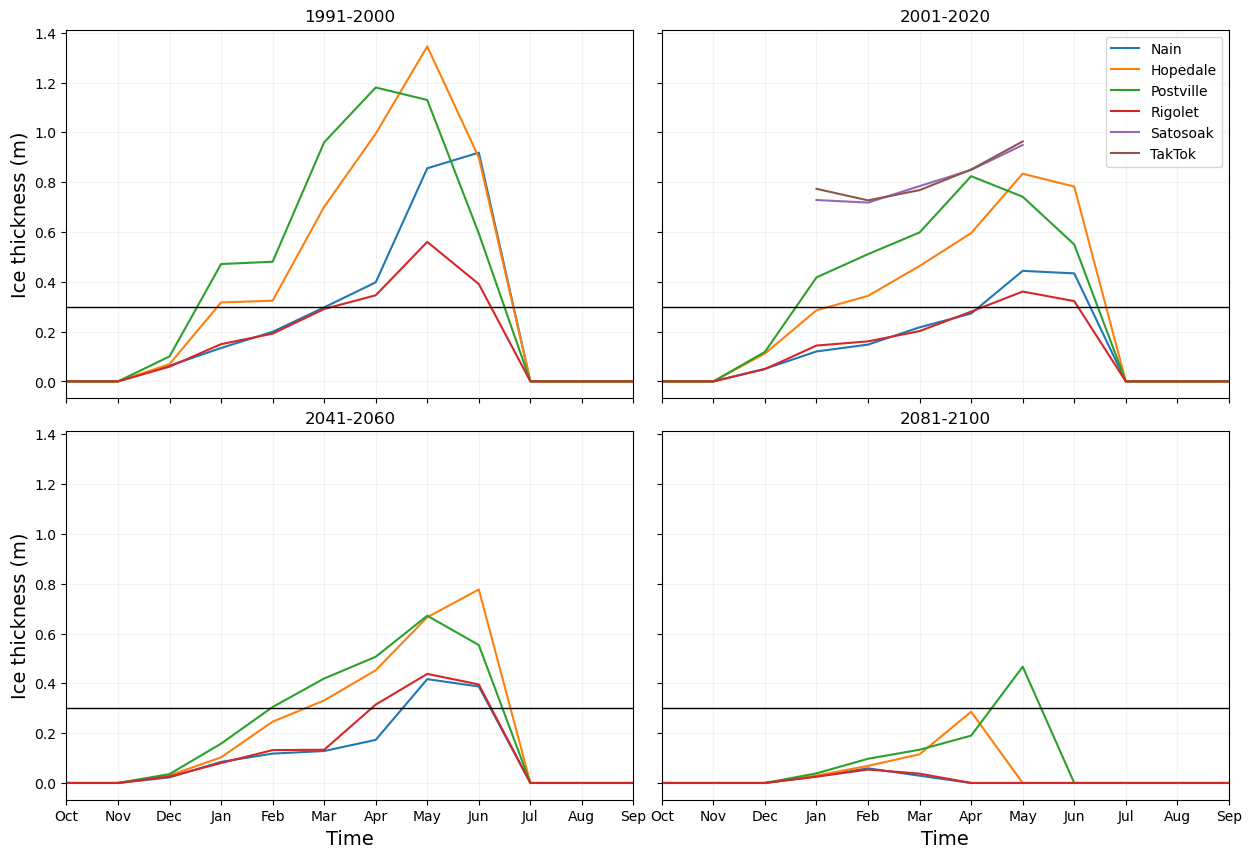

In [137]:
fig, ax=plt.subplots(2,2, figsize=(15,10), sharey=True, sharex=True)
month_dt = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep']
ax[0,0].plot(month_dt, np.append(nain_hi_1991_00[9:],nain_hi_1991_00[:9]) , label='Nain')
ax[0,0].plot(month_dt, np.append(hope_hi_1991_00[9:],hope_hi_1991_00[:9]) , label='Hopedale')
ax[0,0].plot(month_dt, np.append(post_hi_1991_00[9:],post_hi_1991_00[:9]) , label='Postville')
ax[0,0].plot(month_dt, np.append(rigo_hi_1991_00[9:],rigo_hi_1991_00[:9]) , label='Rigolet')
ax[0,0].set_ylabel('Ice thickness (m)', fontsize=14)
ax[0,0].set_title('1991-2000')
ax[0,0].grid(alpha=0.15)
ax[0,0].axhline(y=0.3, color='black', linewidth=1)

ax[0,1].plot(month_dt, np.append(nain_hi_2001_20[9:],nain_hi_2001_20[:9]) , label='Nain')
ax[0,1].plot(month_dt, np.append(hope_hi_2001_20[9:],hope_hi_2001_20[:9]) , label='Hopedale')
ax[0,1].plot(month_dt, np.append(post_hi_2001_20[9:],post_hi_2001_20[:9]) , label='Postville')
ax[0,1].plot(month_dt, np.append(rigo_hi_2001_20[9:],rigo_hi_2001_20[:9]) , label='Rigolet')
ax[0,1].plot(month_dt, np.append(sat_mean_monthly['Hice_Mean'][9:]*0.01, sat_mean_monthly['Hice_Mean'][:9]*0.01), label='Satosoak')
ax[0,1].plot(month_dt, np.append(tak_mean_monthly['Hice_Mean'][9:]*0.01, tak_mean_monthly['Hice_Mean'][:9]*0.01), label='TakTok')
ax[0,1].legend()
ax[0,1].set_title('2001-2020')
ax[0,1].grid(alpha=0.15)
ax[0,1].axhline(y=0.3, color='black', linewidth=1)

ax[1,0].plot(month_dt, np.append(nain_hi_2041_60[9:],nain_hi_2041_60[:9]) )
ax[1,0].plot(month_dt, np.append(hope_hi_2041_60[9:],hope_hi_2041_60[:9]) )
ax[1,0].plot(month_dt, np.append(post_hi_2041_60[9:],post_hi_2041_60[:9]) )
ax[1,0].plot(month_dt, np.append(rigo_hi_2041_60[9:],rigo_hi_2041_60[:9]) )
ax[1,0].set_ylabel('Ice thickness (m)', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('2041-2060')
ax[1,0].grid(alpha=0.15)
ax[1,0].axhline(y=0.3, color='black', linewidth=1)

ax[1,1].plot(month_dt, np.append(nain_hi_2081_100[9:],nain_hi_2081_100[:9]) )
ax[1,1].plot(month_dt, np.append(hope_hi_2081_100[9:],hope_hi_2081_100[:9]) )
ax[1,1].plot(month_dt, np.append(post_hi_2081_100[9:],post_hi_2081_100[:9]) )
ax[1,1].plot(month_dt, np.append(rigo_hi_2081_100[9:],rigo_hi_2081_100[:9]) )
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title('2081-2100')
ax[1,1].grid(alpha=0.15)
ax[1,1].axhline(y=0.3, color='black', linewidth=1)

plt.subplots_adjust(hspace=0.09, wspace=0.05)
plt.xlim(0,11)

plt.savefig('/storage2/tkyeimiah/Plots/cities_timeseries.jpg',dpi=500, bbox_inches='tight')
plt.show()

### SSS

In [138]:
data_hr=xr.open_mfdataset('/storage2/tkyeimiah/SSS/CESM-HR/B*.nc')
data_13lr=xr.open_dataset('/storage2/tkyeimiah/SSS/CESM-LR/SALT.nc')
data_lr=xr.open_mfdataset('/storage2/tkyeimiah/SSS/CESM2-LE/b*.nc')

In [139]:
SSS_hr=shift_month(data_hr['SSS'])
SSS_13lr_=shift_month(data_13lr['SALT'])
SSS_lr=shift_month(data_lr['SSS2'])

In [140]:
SSS_13lr= SSS_13lr_.isel(z_t=0)

In [141]:
np.nanmax(SSS_13lr.values)

44.254795

In [142]:
SSS_lr

<xarray.DataArray 'SSS2' (time: 480, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(480, 384, 320), dtype=float32, chunksize=(120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time     (time) object 2045-01-01 00:00:00 ... 2084-12-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Sea Surface Salinity**2
    units:         (gram/kilogram)**2
    grid_loc:      2110
    cell_methods:  time: mean

In [143]:
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_sss_hr = ((SSS_hr.TLAT >= lat_min) & (SSS_hr.TLAT <= lat_max) & 
               (SSS_hr.TLONG >= lon_min) & (SSS_hr.TLONG <= lon_max))

mask_sss_13lr = ((SSS_13lr.TLAT >= lat_min) & (SSS_13lr.TLAT <= lat_max) & 
               (SSS_13lr.TLONG >= lon_min) & (SSS_13lr.TLONG <= lon_max))

mask_sss_lr = ((SSS_lr.TLAT >= lat_min) & (SSS_lr.TLAT <= lat_max) & 
               (SSS_lr.TLONG >= lon_min) & (SSS_lr.TLONG <= lon_max))

# Apply the mask to the aice variable
SSS_hr_region = SSS_hr.where(mask_sss_hr, drop=True)
SSS_13lr_region = SSS_13lr.where(mask_sss_13lr, drop=True)
SSS_lr_region = SSS_lr.where(mask_sss_lr, drop=True)

In [144]:
SSS_hr_2060_2070 = SSS_hr_region.sel(time=slice('2060','2070'))
SSS_13lr_2060_2070 = SSS_13lr_region.sel(time=slice('2060','2070'))
SSS_lr_2060_2070 = SSS_lr_region.sel(time=slice('2060','2070'))

In [145]:
SSS_hr_2060_2070_march = SSS_hr_2060_2070[2::12].mean(('nlat','nlon'))
SSS_13lr_2060_2070_march = SSS_13lr_2060_2070[2::12].mean(('nlat','nlon'))
SSS_lr_2060_2070_march = SSS_lr_2060_2070[2::12].mean(('nlat','nlon'))

In [146]:
SSS_lr_2060_2070 

<xarray.DataArray 'SSS2' (time: 132, nlat: 50, nlon: 38)>
dask.array<getitem, shape=(132, 50, 38), dtype=float32, chunksize=(72, 50, 38), chunktype=numpy.ndarray>
Coordinates:
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(50, 38), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(50, 38), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(50, 38), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(50, 38), meta=np.ndarray>
  * time     (time) object 2060-01-01 00:00:00 ... 2070-12-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Sea Surface Salinity**2
    units:         (gram/kilogram)**2
    grid_loc:      2110
    cell_methods:  time: mean

In [147]:
# Extract data arrays
SSS_hr = SSS_hr_2060_2070
SSS_lr = SSS_lr_2060_2070

# Get HR and LR coordinates
HR_TLAT = SSS_hr_2060_2070['TLAT']
HR_TLONG = SSS_hr_2060_2070['TLONG']
LR_TLAT = SSS_lr_2060_2070['TLAT']
LR_TLONG = SSS_lr_2060_2070['TLONG']

# Flatten LR coordinates and data
LR_points = np.column_stack((LR_TLAT.values.flatten(), LR_TLONG.values.flatten()))
LR_values = SSS_lr.values.reshape(SSS_lr.shape[0], -1)  # reshape to (time, space)

# Prepare HR grid points
HR_points = np.column_stack((HR_TLAT.values.flatten(), HR_TLONG.values.flatten()))

# Interpolate LR data to HR grid
SSS_lr_upscaled_values = np.array([
    griddata(LR_points, time_slice, HR_points, method='linear').reshape(HR_TLAT.shape)
    for time_slice in LR_values
])

# Create a new DataArray with the upscaled data
SSS_lr_upscaled = xr.DataArray(
    data=SSS_lr_upscaled_values,
    dims=SSS_hr.dims,
    coords=SSS_hr.coords,
    attrs=SSS_lr.attrs
)

# Calculate the difference
SSS_difference = SSS_hr - SSS_lr_upscaled

In [148]:
# Extract data arrays
SSS_hr = SSS_hr_2060_2070
SSS_13lr = SSS_13lr_2060_2070

# Get HR and LR coordinates
HR_TLAT = SSS_hr_2060_2070['TLAT']
HR_TLONG = SSS_hr_2060_2070['TLONG']
LR_TLAT1 = SSS_13lr_2060_2070['TLAT']
LR_TLONG1 = SSS_13lr_2060_2070['TLONG']

# Flatten LR coordinates and data
LR_points1 = np.column_stack((LR_TLAT1.values.flatten(), LR_TLONG1.values.flatten()))
LR_values1 = SSS_13lr.values.reshape(SSS_13lr.shape[0], -1)  # reshape to (time, space)

# Prepare HR grid points
HR_points1 = np.column_stack((HR_TLAT.values.flatten(), HR_TLONG.values.flatten()))

# Interpolate LR data to HR grid
SSS_13lr_upscaled_values = np.array([
    griddata(LR_points1, time_slice, HR_points1, method='linear').reshape(HR_TLAT.shape)
    for time_slice in LR_values1
])

# Create a new DataArray with the upscaled data
SSS_13lr_upscaled = xr.DataArray(
    data=SSS_13lr_upscaled_values,
    dims=SSS_hr.dims,
    coords=SSS_hr.coords,
    attrs=SSS_13lr.attrs
)

# Calculate the difference
SSS_difference1 = SSS_hr - SSS_13lr_upscaled

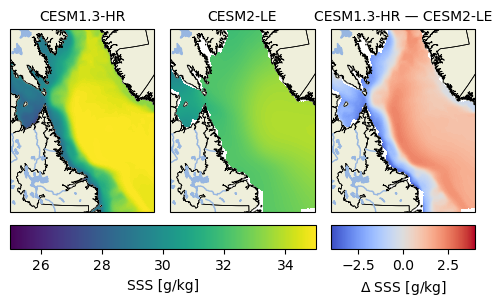

In [149]:
#=========sic_region==max========================
fig = plt.figure(figsize=(6,2.4))
SSS_diff=SSS_hr- np.sqrt(SSS_lr_upscaled)
data = [SSS_hr, np.sqrt(SSS_lr_upscaled), SSS_diff ]
titles = ['CESM1.3-HR', 'CESM2-LE', 'CESM1.3-HR \u2014 CESM2-LE']
# Normalization for color scales
norm = plt.Normalize(vmin=25, vmax=35)
norm1 = plt.Normalize(vmin=-4, vmax=4)

x0, x1, y0, y1 =-68,-48,51,67
  
# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(1,3, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
    if i in [0,1]:
        cs=ax.contourf( data[i][2::12].TLONG, data[i][2::12].TLAT, data[i][2::12].mean('time'),levels=100, norm=norm, cmap='viridis',
               transform=ccrs.PlateCarree(), zorder=1)
    if i ==2:
        cs1=ax.contourf(data[i][2::12].TLONG, data[i][2::12].TLAT, data[i][2::12].mean('time'),levels=100, norm=norm1, cmap='coolwarm',
               transform=ccrs.PlateCarree(), zorder=1)
    
    
# Shared color bar for the first two subplots
cbar_ax = fig.add_axes([0.125, -0.04, 0.51, 0.1])  # Adjust the position as needed
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), cax=cbar_ax, orientation='horizontal',label=('SSS [g/kg]'))
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SSS [g/kg]', fontsize=12)

# Separate color bar for the third subplot
cbar_ax1 = fig.add_axes([0.66, -0.04, 0.24, 0.1])  # Adjust the position as needed
cbar1 = fig.colorbar(cm.ScalarMappable(norm=norm1, cmap='coolwarm'), cax=cbar_ax1, orientation='horizontal',label=('$\Delta$ SSS [g/kg]'))
cbar1.ax.tick_params(labelsize=10)
cbar1.ax.set_ylabel('SSS [g/kg]', fontsize=12)


plt.subplots_adjust(wspace=0.11)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/SSS.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
#=========sic_region==max========================
fig = plt.figure(figsize=(6,2.4))
SSS_diff1=SSS_hr- SSS_13lr_upscaled
data = [SSS_hr, SSS_13lr_upscaled, SSS_diff1 ]
titles = ['CESM1.3-HR', 'CESM1.3-LR', 'CESM1.3-HR \u2014 CESM1.3-LR']
# Normalization for color scales
norm = plt.Normalize(vmin=25, vmax=45)
norm1 = plt.Normalize(vmin=-4, vmax=4)

x0, x1, y0, y1 =-68,-48,51,67
  
# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(1,3, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
    if i in [0,1]:
        cs=ax.contourf( data[i][2::12].TLONG, data[i][2::12].TLAT, data[i][2::12].mean('time'),levels=100, norm=norm, cmap='viridis',
               transform=ccrs.PlateCarree(), zorder=1)
    if i ==2:
        cs1=ax.contourf(data[i][2::12].TLONG, data[i][2::12].TLAT, data[i][2::12].mean('time'),levels=100, norm=norm1, cmap='coolwarm',
               transform=ccrs.PlateCarree(), zorder=1)
    
    
# Shared color bar for the first two subplots
cbar_ax = fig.add_axes([0.125, -0.04, 0.51, 0.1])  # Adjust the position as needed
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), cax=cbar_ax, orientation='horizontal',label=('SSS [g/kg]'))
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SSS [g/kg]', fontsize=12)

# Separate color bar for the third subplot
cbar_ax1 = fig.add_axes([0.66, -0.04, 0.24, 0.1])  # Adjust the position as needed
cbar1 = fig.colorbar(cm.ScalarMappable(norm=norm1, cmap='coolwarm'), cax=cbar_ax1, orientation='horizontal',label=('$\Delta$ SSS [g/kg]'))
cbar1.ax.tick_params(labelsize=10)
cbar1.ax.set_ylabel('SSS [g/kg]', fontsize=12)


plt.subplots_adjust(wspace=0.11)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/SSS_2.jpg',dpi=500, bbox_inches='tight')
plt.show()